Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!

  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github

# CoronaVirus Prediction

### Number of Day to Predict 42

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=42
num_BackTrack_Days=4

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=24 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
## DROP_N=550 => 25/07/2021
#
drop_n_dataset_days=550
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
254                                           NaN                 Tunisia   
255                                           NaN                  Turkey   
256                                           NaN           United States   
257                                           NaN                  Uganda   
258                                           NaN                 Ukraine   
259                                           NaN    United Arab Emirates   
260                                      Anguilla          United Kingdom   
261                                       Bermuda          United Kingdom   
262                        British Virgin Islands          United Kingdom   
263                                Cayman Islands          United Kingdom   
264                               Channel Islands          United Kingdom   
265                   Falkland Islands (Malvinas)          United Kingdom   
266                                     Gibraltar          United Kingdom   
267                                      Guernsey          United Kingdom   
268                                   Isle of Man          United Kingdom   
269                                        Jersey          United Kingdom   
270                                    Montserrat          United Kingdom   
271  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
272                      Turks and Caicos Islands          United Kingdom   
273                                           NaN          United Kingdom   
274                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
260                                           NaN                 Tunisia   
261                                           NaN                  Turkey   
262                                           NaN           United States   
263                                           NaN                  Uganda   
264                                           NaN                 Ukraine   
265                                           NaN    United Arab Emirates   
266                                      Anguilla          United Kingdom   
267                                       Bermuda          United Kingdom   
268                        British Virgin Islands          United Kingdom   
269                                Cayman Islands          United Kingdom   
270                               Channel Islands          United Kingdom   
271                   Falkland Islands (Malvinas)          United Kingdom   
272                                     Gibraltar          United Kingdom   
273                                      Guernsey          United Kingdom   
274                                   Isle of Man          United Kingdom   
275                                        Jersey          United Kingdom   
276                                    Montserrat          United Kingdom   
277  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
278                      Turks and Caicos Islands          United Kingdom   
279                                           NaN          United Kingdom   
280                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN              Mali  17.570692   -3.996166        0        0   
186            NaN             Malta  35.937500   14.375400        0        0   
187            NaN  Marshall Islands   7.131500  171.184500        0        0   
188            NaN        Mauritania  21.007900  -10.940800        0        0   
189            NaN         Mauritius -20.348404   57.552152        0        0   
190            NaN            Mexico  23.634500 -102.552800        0        0   
191            NaN        Micronesia   7.425600  150.550800        0        0   
192            NaN           Moldova  47.411600   28.369900        0        0   
193            NaN            Monaco  43.733300    7.416700        0        0   
194            NaN          Mongolia  46.862500  103.846700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  4/18/22  4/19/22  4/20/22  \
185        0        0        0        0  ...      729      730      730   
186        0        0        0        0  ...      677      677      679   
187        0        0        0        0  ...        0        0        0   
188        0        0        0        0  ...      982      982      982   
189        0        0        0        0  ...      990      990      990   
190        0        0        0        0  ...   323944   323973   324004   
191        0        0        0        0  ...        0        0        0   
192        0        0        0        0  ...    11482    11485    11487   
193        0        0        0        0  ...       56       56       56   
194        0        0        0        0  ...     2177     2177     2177   

     4/21/22  4/22/22  4/23/22  4/24/22  4/25/22   Population   \
185      731      731      731      731      731    20,250,833   
186      684      684      687      688      692       441,543   
187        0        0        0        0        0           NaN   
188      982      982      982      982      982     4,649,658   
189      990      990      990      990      990     1,273,985   
190   324033   324033   324120   324129   324134   128,640,794   
191        0        0        0        0        0           NaN   
192    11487    11489    11489    11489    11489     4,035,942   
193       56       56       56       56       57        39,183   
194     2177     2177     2177     2177     2177     3,278,290   

                   region  
185              Mali_nan  
186             Malta_nan  
187  Marshall Islands_nan  
188        Mauritania_nan  
189         Mauritius_nan  
190            Mexico_nan  
191        Micronesia_nan  
192           Moldova_nan  
193            Monaco_nan  
194          Mongolia_nan  

[10 rows x 831 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN        Moldova  47.411600   28.36990   
176                               NaN         Monaco  43.733300    7.41670   
177                               NaN       Mongolia  46.862500  103.84670   
178                               NaN     Montenegro  42.708678   19.37439   
179                               NaN        Morocco  31.791700   -7.09260   
180                               NaN     Mozambique -18.665700   35.52960   
181                               NaN        Namibia -22.957600   18.49040   
182                               NaN          Nepal  28.166700   84.25000   
183                             Aruba    Netherlands  12.521100  -69.96830   
184  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  4/18/22  \
175        0        0        0        0        0        0  ...        0   
176        0        0        0        0        0        0  ...        0   
177        0        0        0        0        0        0  ...        0   
178        0        0        0        0        0        0  ...        0   
179        0        0        0        0        0        0  ...        0   
180        0        0        0        0        0        0  ...        0   
181        0        0        0        0        0        0  ...        0   
182        0        0        0        0        0        0  ...        0   
183        0        0        0        0        0        0  ...        0   
184        0        0        0        0        0        0  ...        0   

     4/19/22  4/20/22  4/21/22  4/22/22  4/23/22  4/24/22  4/25/22  \
175        0        0        0        0        0        0        0   
176        0        0        0        0        0        0        0   
177        0        0        0        0        0        0        0   
178        0        0        0        0        0        0        0   
179        0        0        0        0        0        0        0   
180        0        0        0        0        0        0        0   
181        0        0        0        0        0        0        0   
182        0        0        0        0        0        0        0   
183        0        0        0        0        0        0        0   
184        0        0        0        0        0        0        0   

      Population                                         region  
175     4,035,942                                   Moldova_nan  
176        39,183                                    Monaco_nan  
177     3,278,290                                  Mongolia_nan  
178       622 500                                Montenegro_nan  
179    36,817,128                                   Morocco_nan  
180    31,542,919                                Mozambique_nan  
181     2,540,905                                   Namibia_nan  
182    29,300,000                                     Nepal_nan  
183       116,600                             Netherlands_Aruba  
184        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 831 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN              Mali  17.570692   -3.996166        0        0   
186            NaN             Malta  35.937500   14.375400        0        0   
187            NaN  Marshall Islands   7.131500  171.184500        0        0   
188            NaN        Mauritania  21.007900  -10.940800        0        0   
189            NaN         Mauritius -20.348404   57.552152        0        0   
190            NaN            Mexico  23.634500 -102.552800        0        0   
191            NaN        Micronesia   7.425600  150.550800        0        0   
192            NaN           Moldova  47.411600   28.369900        0        0   
193            NaN            Monaco  43.733300    7.416700        0        0   
194            NaN          Mongolia  46.862500  103.846700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  4/18/22  4/19/22  4/20/22  \
185        0        0        0        0  ...    30669    30678    30691   
186        0        0        0        0  ...    89028    89310    89607   
187        0        0        0        0  ...       14       15       15   
188        0        0        0        0  ...    58683    58683    58683   
189        0        0        0        0  ...   218229   218229   220344   
190        0        0        0        0  ...  5727668  5729270  5730560   
191        0        0        0        0  ...        1        1        1   
192        0        0        0        0  ...   516444   516587   516699   
193        0        0        0        0  ...    11341    11480    11520   
194        0        0        0        0  ...   920119   920240   920291   

     4/21/22  4/22/22  4/23/22  4/24/22  4/25/22   Population   \
185    30700    30716    30727    30740    30752    20,250,833   
186    89919    90168    90399    90595    90773       441,543   
187       15       15       15       15       17           NaN   
188    58683    58683    58683    58683    58685     4,649,658   
189   220344   220344   220344   220344   220344     1,273,985   
190  5731635  5731635  5733428  5733785  5733925   128,640,794   
191        1        1        1        1        3           NaN   
192   516864   516986   516986   516986   516986     4,035,942   
193    11545    11577    11604    11604    11632        39,183   
194   920332   920361   920361   920361   920436     3,278,290   

                   region  
185              Mali_nan  
186             Malta_nan  
187  Marshall Islands_nan  
188        Mauritania_nan  
189         Mauritius_nan  
190            Mexico_nan  
191        Micronesia_nan  
192           Moldova_nan  
193            Monaco_nan  
194          Mongolia_nan  

[10 rows x 831 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                            Poland  51.919400   19.145100   
221            NaN                          Portugal  39.399900   -8.224500   
222            NaN                             Qatar  25.354800   51.183900   
223            NaN                           Romania  45.943200   24.966800   
224            NaN                            Russia  61.524010  105.318756   
225            NaN                            Rwanda  -1.940300   29.873900   
226            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
227            NaN                       Saint Lucia  13.909400  -60.978900   
228            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
229            NaN                             Samoa -13.759000 -172.104600   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...   4/18/22  \
220        0        0        0        0        0        0  ...   5985517   
221        0        0        0        0        0        0  ...   3719485   
222        0        0        0        0        0        0  ...    363654   
223        0        0        0        0        0        0  ...   2882590   
224        0        0        0        0        0        0  ...  17820486   
225        0        0        0        0        0        0  ...    129760   
226        0        0        0        0        0        0  ...      5559   
227        0        0        0        0        0        0  ...     23094   
228        0        0        0        0        0        0  ...      8348   
229        0        0        0        0        0        0  ...      5947   

      4/19/22   4/20/22   4/21/22   4/22/22   4/23/22   4/24/22   4/25/22  \
220   5985818   5987341   5988518   5989614   5990853   5991197   5991464   
221   3745569   3757590   3770584   3781160   3791744   3791744   3791744   
222    363754    363828    363905    364012    364089    364187    364300   
223   2884114   2885221   2886284   2887258   2887824   2888318   2888639   
224  17829009  17838087  17846818  17855661  17864332  17872625  17880154   
225    129769    129769    129769    129772    129772    129772    129785   
226      5561      5561      5561      5561      5561      5561      5562   
227     23111     23161     23161     23201     23239     23239     23285   
228      8352      8355      8378      8383      8383      8383      8394   
229      6309      6794      6794      7185      7185      7185      7185   

      Population                                 region  
220    37,980,000                            Poland_nan  
221    10,290,000                          Portugal_nan  
222     2,870,256                             Qatar_nan  
223    19,530,000                           Romania_nan  
224   144,500,000                            Russia_nan  
225    12,952,218                            Rwanda_nan  
226        53,673             Saint Kitts and Nevis_nan  
227       184,106                       Saint Lucia_nan  
228       110,940  Saint Vincent and the Grenadines_nan  
229           NaN                             Samoa_nan  

[10 rows x 831 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

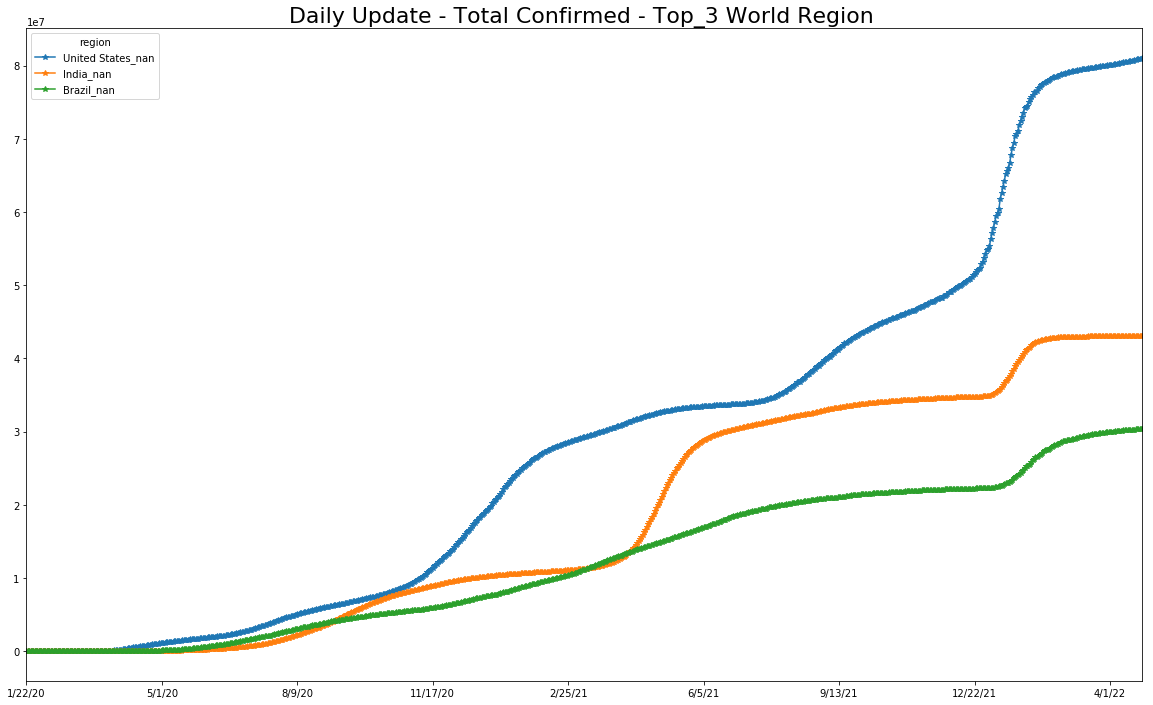

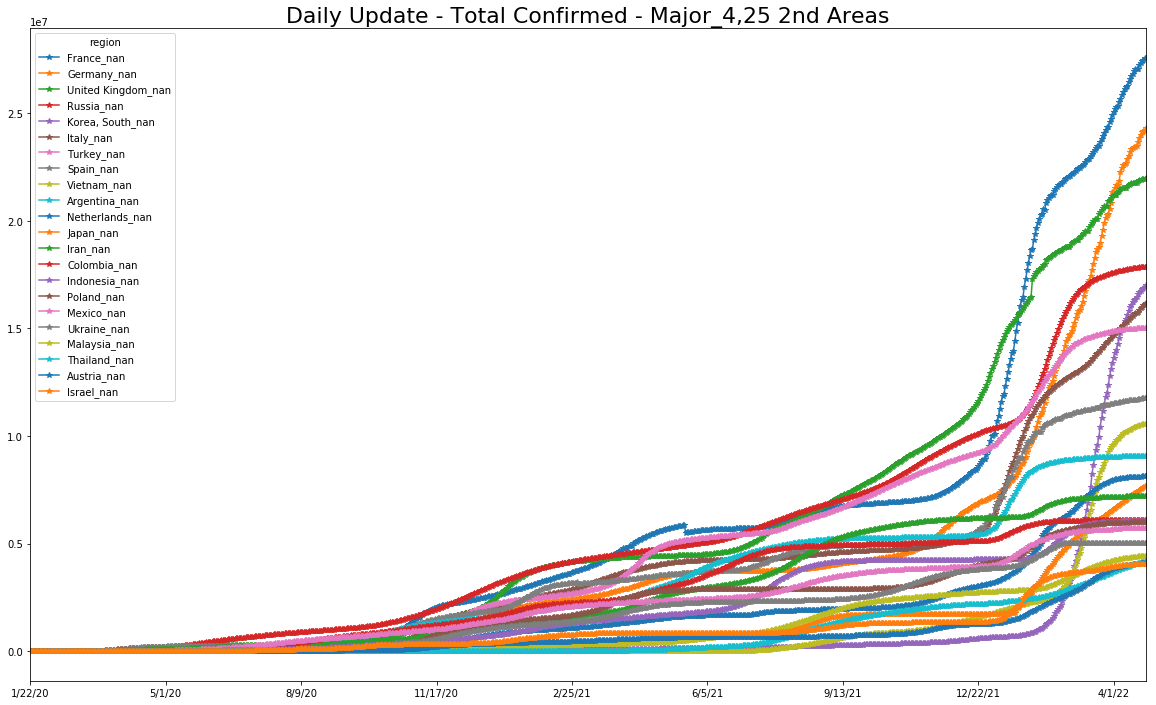

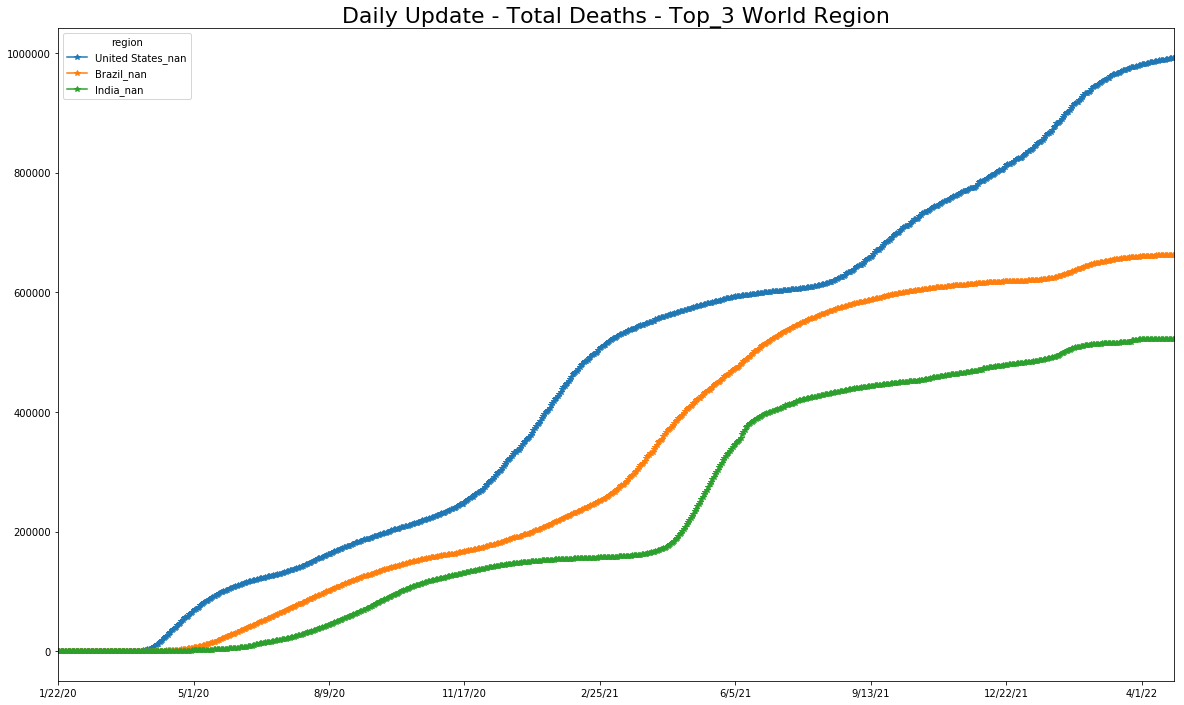

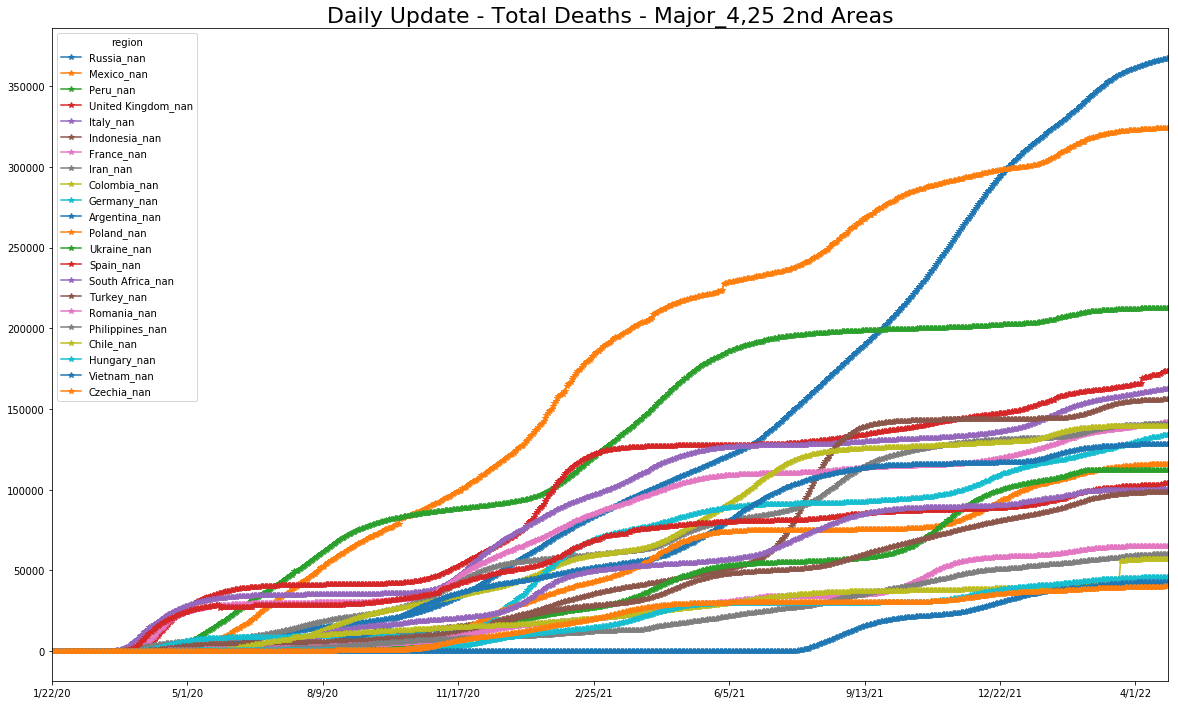

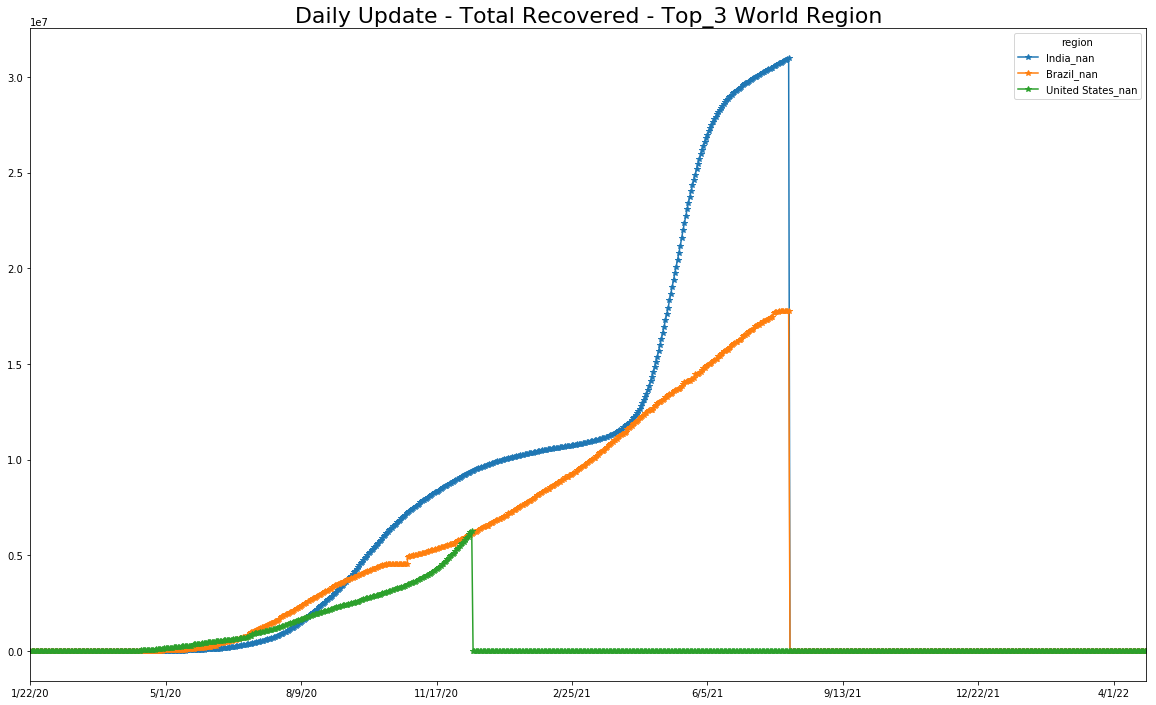

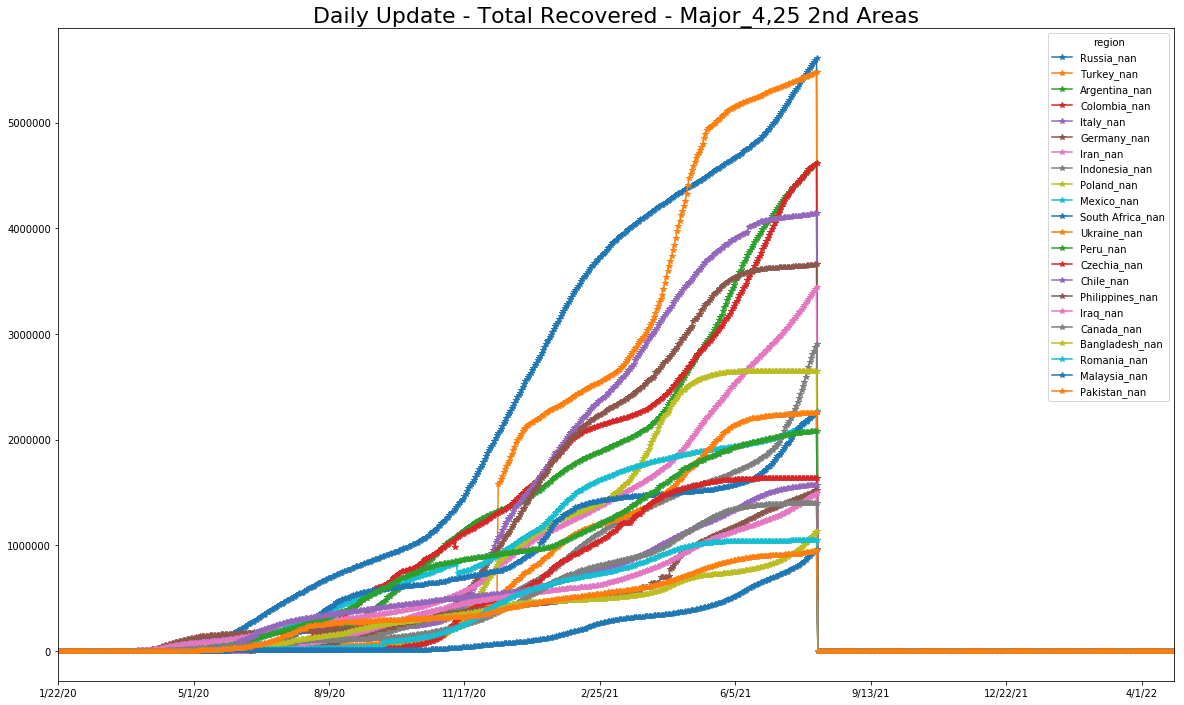

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/04/26


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/25/21           143871       132875       162155        14498       41780   
7/26/21           144285       132891       163660        14577       41879   
7/27/21           145008       132922       165204        14586       42110   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/25/21               0                     1280        4846615       228798   
7/26/21               0                     1280        4859170       228910   
7/27/21               0                     1288        4875927       229090   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
7/25/21                                     124  ...       380431   
7/26/21                                     124  ...       380584   
7/27/21                                     124  ...       380793   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
7/25/21          124290            4         299822       101173   
7/26/21          124995            4         300919       106347   
7/27/21          125784            4         301979       117121   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
7/25/21                  316088                         0       7012   
7/26/21                  316088                         0       7012   
7/27/21                  316189                         0       7022   

region   Zambia_nan  Zimbabwe_nan  
7/25/21      192071         97894  
7/26/21      192316         99944  
7/27/21      192956        101711  

[3 rows x 284 columns]

In [25]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
4/22/22           178638       274737       265761        41013       99287   
4/23/22           178648       274791       265761        41013       99287   
4/24/22           178689       274828       265767        41013       99287   
4/25/22           178745       274828       265771        41013       99287   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
4/22/22              11                     7571        9060923       422814   
4/23/22              11                     7571        9060923       422822   
4/24/22              11                     7571        9060923       422825   
4/25/22              11                     7571        9072230       422828   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
4/22/22                                   98760  ...       895775   
4/23/22                                   99485  ...       895775   
4/24/22                                   99485  ...       895775   
4/25/22                                  100927  ...       895775   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
4/22/22          238428         6537         522088     10544324   
4/23/22          238442         6793         522121     10554689   
4/24/22          238469         6840         522176     10563502   
4/25/22          238503         6860         522234     10571772   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
4/22/22                  656876                       535      11818   
4/23/22                  656876                       535      11818   
4/24/22                  656876                       535      11818   
4/25/22                  656876                       535      11818   

region   Zambia_nan  Zimbabwe_nan  
4/22/22      318984        247488  
4/23/22      318984        247524  
4/24/22      318984        247524  
4/25/22      319316        247598  

[4 rows x 284 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-07-26  Afghanistan_nan     144285             0             0   
2     2021-07-27  Afghanistan_nan     145008           414             0   
3     2021-07-28  Afghanistan_nan     145552           723             0   
4     2021-07-29  Afghanistan_nan     145996           544          1681   
5     2021-07-30  Afghanistan_nan     146523           444          1711   
6     2021-07-31  Afghanistan_nan     147154           527          1515   
7     2021-08-01  Afghanistan_nan     147501           631          1602   
8     2021-08-02  Afghanistan_nan     147985           347          1505   
9     2021-08-03  Afghanistan_nan     148572           484          1462   
10    2021-08-04  Afghanistan_nan     148933           587          1418   
11    2021-08-05  Afghanistan_nan     149361           361          1432   
12    2021-08-06  Afghanistan_nan     149810           428          1376   
13    2021-08-07  Afghanistan_nan     150240           449          1238   
14    2021-08-08  Afghanistan_nan     150458           430          1307   
15    2021-08-09  Afghanistan_nan     150778           218          1097   
16    2021-08-10  Afghanistan_nan     151013           320           968   
17    2021-08-11  Afghanistan_nan     151291           235           773   
18    2021-08-12  Afghanistan_nan     151563           278           833   
19    2021-08-13  Afghanistan_nan     151770           272           785   
20    2021-08-14  Afghanistan_nan     151941           207           757   
21    2021-08-15  Afghanistan_nan     152033           171           650   
22    2021-08-16  Afghanistan_nan     152142            92           470   
23    2021-08-17  Afghanistan_nan     152243           109           372   
24    2021-08-18  Afghanistan_nan     152363           101           302   
25    2021-08-19  Afghanistan_nan     152411           120           330   
26    2021-08-20  Afghanistan_nan     152448            48           269   
27    2021-08-21  Afghanistan_nan     152497            37           205   
28    2021-08-22  Afghanistan_nan     152511            49           134   
29    2021-08-23  Afghanistan_nan     152583            14           100   
30    2021-08-24  Afghanistan_nan     152660            72           135   
...          ...              ...        ...           ...           ...   
80010 2022-03-28     Zimbabwe_nan     245927           175           626   
80011 2022-03-29     Zimbabwe_nan     246042           107           282   
80012 2022-03-30     Zimbabwe_nan     246182           115           397   
80013 2022-03-31     Zimbabwe_nan     246286           140           362   
80014 2022-04-01     Zimbabwe_nan     246414           104           359   
80015 2022-04-02     Zimbabwe_nan     246481           128           372   
80016 2022-04-03     Zimbabwe_nan     246525            67           299   
80017 2022-04-04     Zimbabwe_nan     246612            44           239   
80018 2022-04-05     Zimbabwe_nan     246744            87           198   
80019 2022-04-06     Zimbabwe_nan     246803           132           263   
80020 2022-04-07     Zimbabwe_nan     246870            59           278   
80021 2022-04-08     Zimbabwe_nan     246925            67           258   
80022 2022-04-09     Zimbabwe_nan     246925            55           181   
80023 2022-04-10     Zimbabwe_nan     246958             0           122   
80024 2022-04-11     Zimbabwe_nan     247010            33            88   
80025 2022-04-12     Zimbabwe_nan     247094            52            85   
80026 2022-04-13     Zimbabwe_nan     247160            84           169   
80027 2022-04-14     Zimbabwe_nan     247208            66           202   
80028 2022-04-15     Zimbabwe_nan     247237            48           198   
80029 2022-04-16     Zimbabwe_nan     247237            29           143   
80030 2022-04-17     Zimbabwe_nan     247278             0  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
80039 2022-04-26  Zimbabwe_nan          0            74           110   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
80039           301           100.0299         100.044451          100.12172   

       last_day  kalman_prediction  population  infected_rate  min  max  
80039    247598           247632.0    14862924       0.000167  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
80039 2022-04-26  Zimbabwe_nan          0            74           110   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
80039           301           100.0299         100.044451          100.12172   

       last_day  kalman_prediction  population  infected_rate  min  max  
80039    247598           247632.0    14862924       0.000167  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
78381  2022-04-24  Zimbabwe_nan     247524            36           188   
78382  2022-04-25  Zimbabwe_nan     247598             0           141   
78383  2022-04-26  Zimbabwe_nan          0            74           110   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
78381           287         100.014550         100.076014         100.116087   
78382           246         100.000004         100.057001         100.099487   
78383           301         100.029900         100.044451         100.121720   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
78381               247524  ...    14862924       0.000167  NaN  NaN   
78382               247524  ...    14862924       0.000167  NaN  NaN   
78383               247598  ...    14862924       0.000167  NaN  NaN   

       population_percentage : infected_rate confirmed  \
78381                                         0.016654   
78382                                         0.016654   
78383                                         0.016659   

       population_percentage : factor 9/10 infected_rate confirmed  \
78381                                           0.149885             
78382                                           0.149885             
78383                                           0.149930             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
78381                    21.0                           1.412912   
78382                    53.0                           3.565920   
78383                    34.0                           2.287571   

       delta : roling 7day AVG  \
78381                41.000000   
78382                35.142857   
78383                43.000000   

       delta : aprox 14-day case notification rate per 100k hab  
78381                                           3.861959         
78382                                           3.310250         
78383                                           4.050347         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
273  United States_nan  2.404784e+13  4.903860e+06  400580.574545


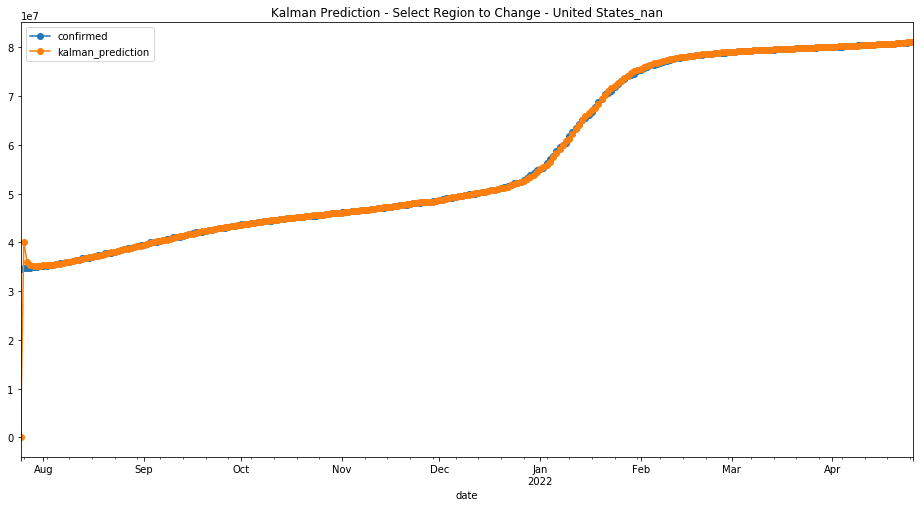

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse           mae
218  Russia_nan  1.167534e+12  1.080525e+06  80332.043636


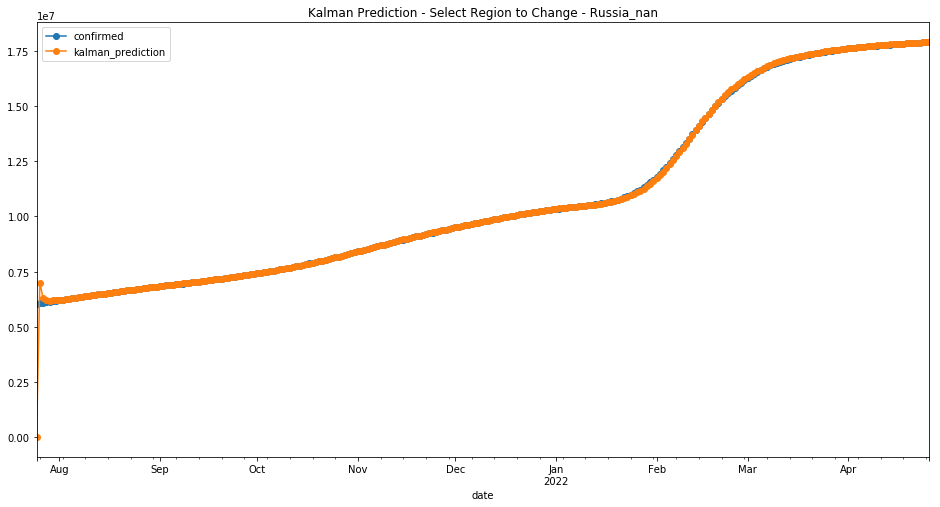

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
31  Brazil_nan  3.393443e+12  1.842130e+06  147562.181818


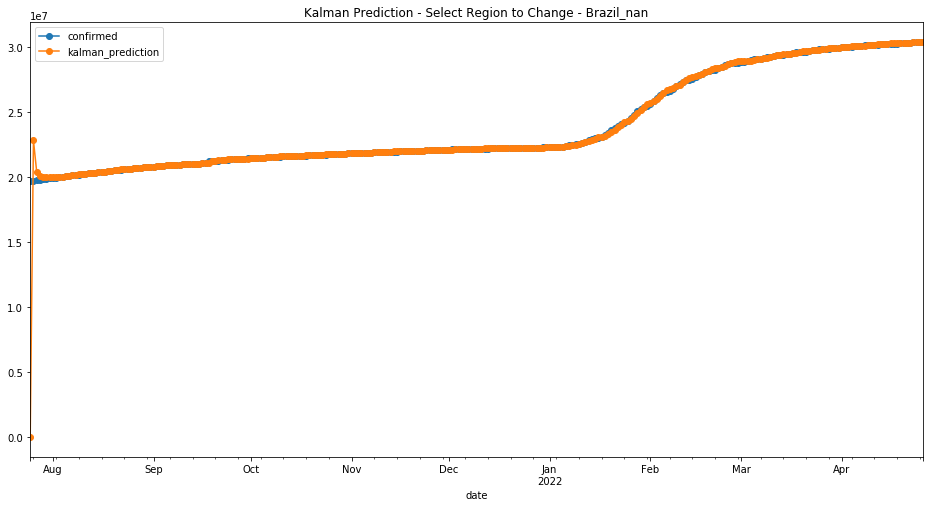

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse            mae
272  United Kingdom_nan  1.767083e+12  1.329317e+06  113529.501818


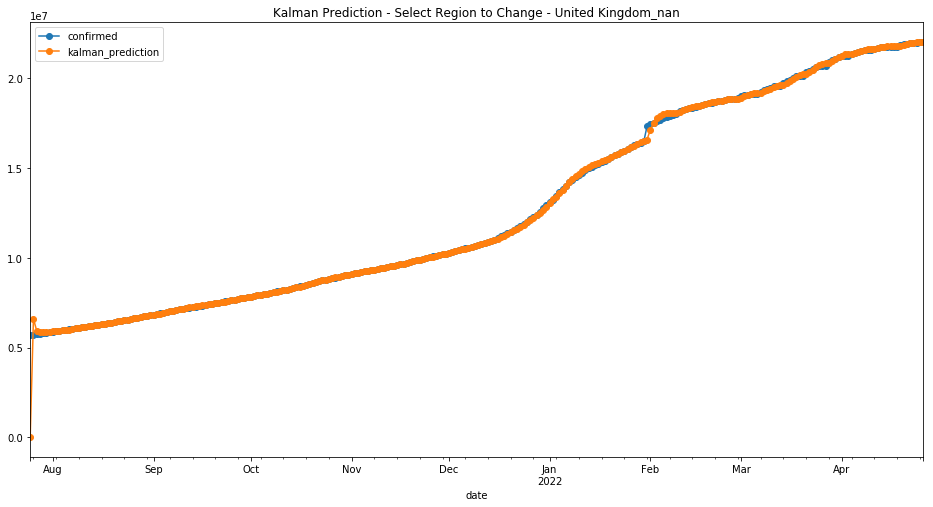

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14.1" 2022-02-08; OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxw23znv8
  JVM stdout: /tmp/tmpxw23znv8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxw23znv8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 5 months and 30 days !!!
H2O cluster name:           H2O_from_python_unknownUser_nefi1a
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-04-02
last_train_date= 2022-04-25
first_bootstrap_date= 2022-04-17
boost_bootstrap_date= 2022-04-22
first_test_date= 2022-04-16
last_test_date= 2022-04-26
first_valid_date= 2022-04-24


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   180114.0     178418 2022-04-17  Afghanistan_nan
1   180133.0     178457 2022-04-18  Afghanistan_nan
2   180168.0     178513 2022-04-19  Afghanistan_nan
3   180215.0     178574 2022-04-20  Afghanistan_nan
4   180268.0     178611 2022-04-21  Afghanistan_nan
5   180311.0     178638 2022-04-22  Afghanistan_nan
6   180342.0     178648 2022-04-23  Afghanistan_nan
7   180356.0     178689 2022-04-24  Afghanistan_nan
8   180387.0     178745 2022-04-25  Afghanistan_nan
9   180434.0          0 2022-04-26  Afghanistan_nan
10  275455.0     274504 2022-04-17      Albania_nan
11  275500.0     274520 2022-04-18      Albania_nan
12  275516.0     274535 2022-04-19      Albania_nan
13  275533.0     274606 2022-04-20      Albania_nan
14  275597.0     274606 2022-04-21      Albania_nan
15  275596.0     274737 2022-04-22      Albania_nan
16  275723.0     274791 2022-04-23      Albania_nan
17  275773.0     274828 2022-04-24      Albania_nan
18  275827.0     274828 2022-04-25      Albania_nan
19  275835.0          0 2022-04-26      Albania_nan
20  267382.0     265739 2022-04-17      Algeria_nan
21  267382.0     265741 2022-04-18      Algeria_nan
22  267384.0     265746 2022-04-19      Algeria_nan
23  267388.0     265746 2022-04-20      Algeria_nan
24  267387.0     265754 2022-04-21      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  4090256.0    4092513 2022-04-22     Austria_nan
176  4096962.0    4099049 2022-04-23     Austria_nan
177  4103733.0    4104859 2022-04-24     Austria_nan
178  4109722.0    4108970 2022-04-25     Austria_nan
179  4113395.0          0 2022-04-26     Austria_nan
180   793340.0     792362 2022-04-17  Azerbaijan_nan
181   793346.0     792365 2022-04-18  Azerbaijan_nan
182   793348.0     792391 2022-04-19  Azerbaijan_nan
183   793378.0     792412 2022-04-20  Azerbaijan_nan
184   793395.0     792445 2022-04-21  Azerbaijan_nan
185   793430.0     792457 2022-04-22  Azerbaijan_nan
186   793439.0     792476 2022-04-23  Azerbaijan_nan
187   793464.0     792496 2022-04-24  Azerbaijan_nan
188   793483.0     792496 2022-04-25  Azerbaijan_nan
189   793480.0          0 2022-04-26  Azerbaijan_nan
190    34492.0      33391 2022-04-17     Bahamas_nan
191    34500.0      33411 2022-04-18     Bahamas_nan
192    34472.0      33411 2022-04-19     Bahamas_nan
193    34519.0      33421 2022-04-20     Bahamas_nan
194    34507.0      33430 2022-04-21     Bahamas_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date        region
220   64648.0      64348 2022-04-17  Barbados_nan
221   64825.0      64794 2022-04-18  Barbados_nan
222   64738.0      65096 2022-04-19  Barbados_nan
223   65135.0      65770 2022-04-20  Barbados_nan
224   65392.0      66317 2022-04-21  Barbados_nan
225   66076.0      66810 2022-04-22  Barbados_nan
226   66690.0      67256 2022-04-23  Barbados_nan
227   67220.0      67611 2022-04-24  Barbados_nan
228   67690.0      67934 2022-04-25  Barbados_nan
229   68058.0          0 2022-04-26  Barbados_nan
230  975446.0     974478 2022-04-17   Belarus_nan
231  975799.0     974714 2022-04-18   Belarus_nan
232  976078.0     974961 2022-04-19   Belarus_nan
233  976297.0     975566 2022-04-20   Belarus_nan
234  976903.0     976261 2022-04-21   Belarus_nan
235  977516.0     976906 2022-04-22   Belarus_nan
236  978118.0     977434 2022-04-23   Belarus_nan
237  978654.0     977813 2022-04-24   Belarus_nan
238  979035.0     977962 2022-04-25   Belarus_nan
239  979153.0          0 2022-04-26   Belarus_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  135212407449.95099
# MSE on the validation data =  113899668407929.78
# R^2 on the training data =  0.9990624666526612
# R^2 on the validation data =  0.37642497587979884


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1650956566571_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 135212407449.95099
RMSE: 367712.39773762185
MAE: 26919.732106245836
RMSLE: 0.3744048648633366
Mean Residual Deviance: 135212407449.95099

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 113899668407929.78
RMSE: 10672378.760516785
MAE: 3453580.8338525603
RMSLE: 8.629568421885343
Mean Residual Deviance: 113899668407929.78
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2022-04-26 07:02:55  0.075 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2022-04-26 07:02:55  0.584 sec   1.0                878976.5545673945   104688.08677731402  772599783479.1678    10556636.517803567  3476346.106483803   111442574569023.81
     2022-04-26 07:02:55  0.754 sec   2.0                688256.8476978715   86968.23839765493   473697488403.01105   10592614.476730721  3435004.9574037157  112203481452645.27
     2022-04-26 07:02:55  0.917 sec   3.0                566048.2841640958   71086.35158264519   320410660005.11694   10631982.057883704  3441459.0867386097  113039042479161.02
     2022-04-26 07:02:56  1.148 sec   4.0                409690.74497070507  64098.225622520644  167846506514.6513    10635448.050429573  3443961.201953888   113112755233386.2
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2022-04-26 07:03:11  16.254 sec  241.0              365058.62725906516  28657.252127804713  133267801336.27306   10657995.306642475  3452760.728654938   113592863956413.02
     2022-04-26 07:03:15  20.288 sec  315.0              365074.45166005247  27650.714347142875  133279355254.88799   10668748.342067374  3453171.206106118   113822191186365.33
     2022-04-26 07:03:19  24.323 sec  384.0              369318.3286382053   26833.816580774735  136396027868.11742   10671342.083673293  3453358.858947606   113877541866776.66
     2022-04-26 07:03:23  28.327 sec  452.0              365990.06538077793  26783.66589890992   133948727957.42612   10672431.150219778  3453442.133856224   113900786656181.44
     2022-04-26 07:03:26  31.246 sec  500.0              367712.39773762185  26919.732106245836  135212407449.95099   10672378.760516785  3453580.8338525603  113899668407929.78


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  2.35483e+20            1                    0.363428
last_day           1.93725e+20            0.822668             0.298981
region             1.40129e+20            0.595072             0.216266
7_day_change       2.89615e+19            0.122988             0.0446972
3_day_change       1.70103e+19            0.0722359            0.0262526
infected_rate      1.47175e+19            0.0624991            0.0227139
1_day_change       1.03281e+19            0.043859             0.0159396
7_day_change_rate  3.35161e+18            0.0142329            0.00517264
3_day_change_rate  2.53963e+18            0.0107848            0.00391949
1_day_change_rate  1.70397e+18            0.00723605           0.00262979

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         2.354831e+20           1.000000    0.363428
1           last_day         1.937245e+20           0.822668    0.298981
2             region         1.401294e+20           0.595072    0.216266
3       7_day_change         2.896151e+19           0.122988    0.044697
4       3_day_change         1.701033e+19           0.072236    0.026253
5      infected_rate         1.471749e+19           0.062499    0.022714
6       1_day_change         1.032806e+19           0.043859    0.015940
7  7_day_change_rate         3.351609e+18           0.014233    0.005173
8  3_day_change_rate         2.539630e+18           0.010785    0.003919
9  1_day_change_rate         1.703969e+18           0.007236    0.002630

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


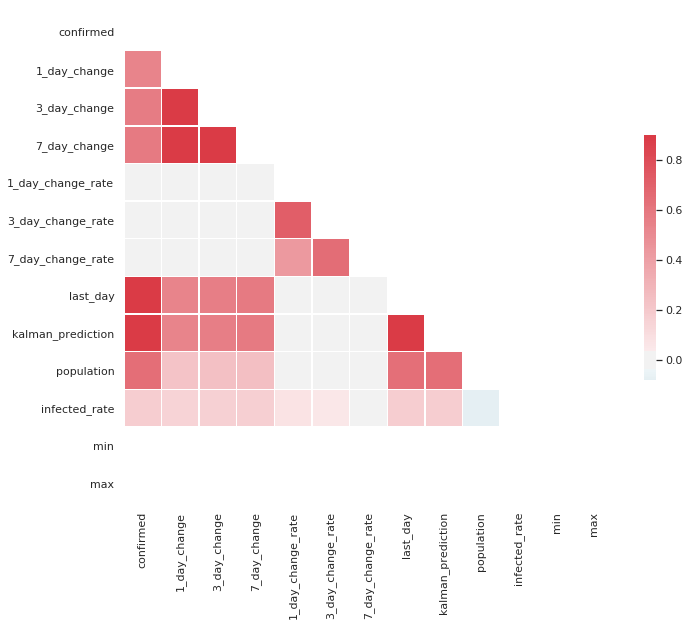

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.538671
3_day_change         0.570634
7_day_change         0.588517
1_day_change_rate    0.017300
3_day_change_rate    0.008741
7_day_change_rate   -0.001399
last_day             0.994644
kalman_prediction    0.995460
population           0.640330
infected_rate        0.175977
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


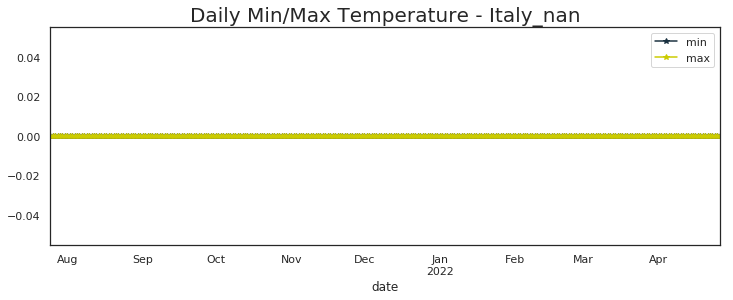

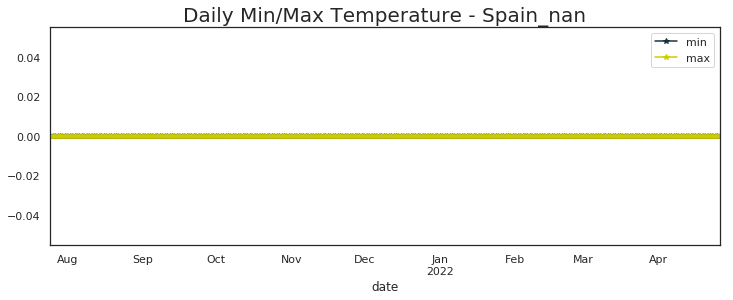

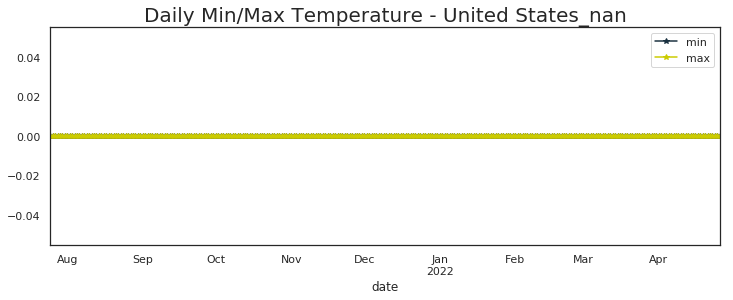

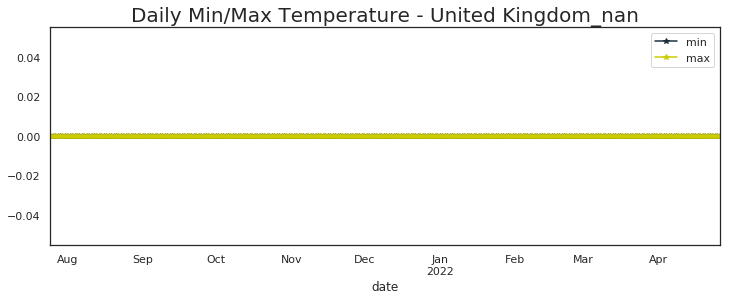

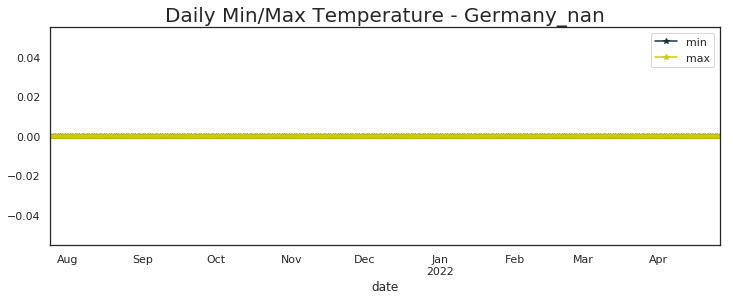

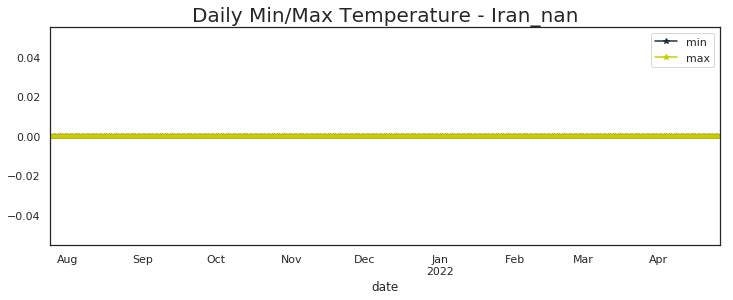

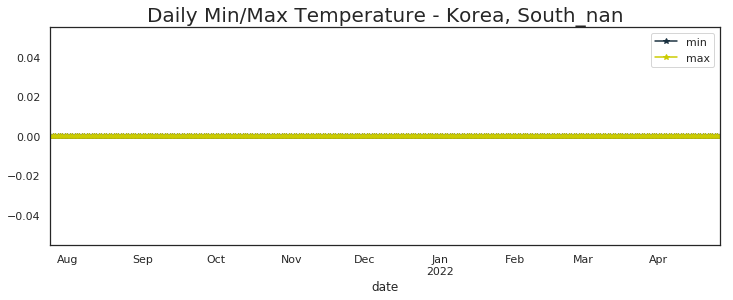

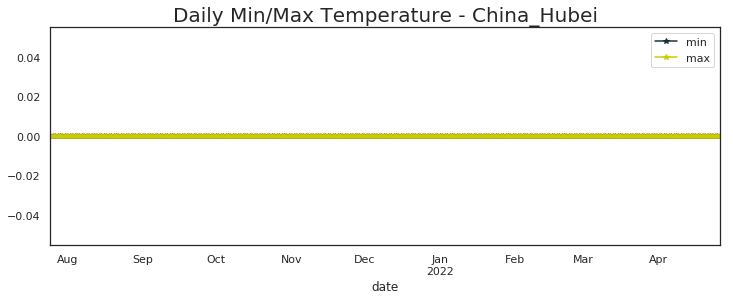

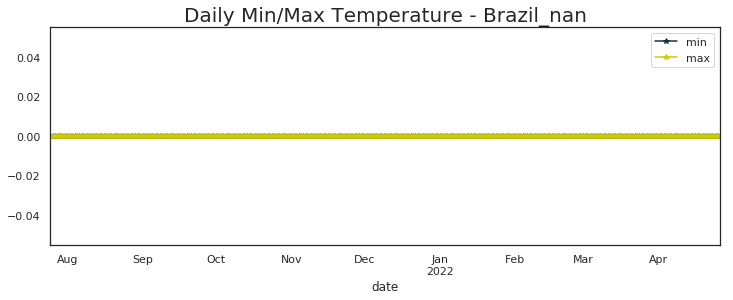

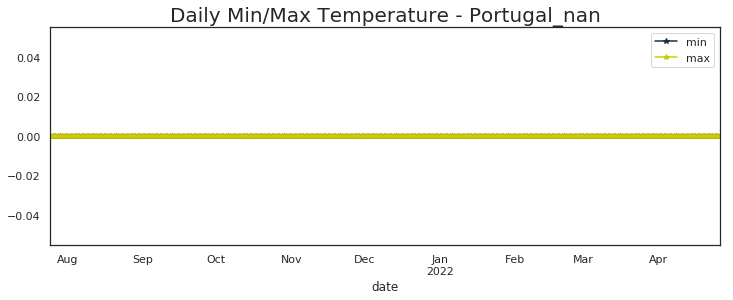

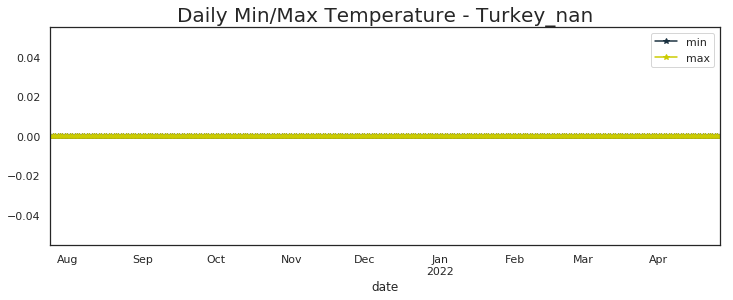

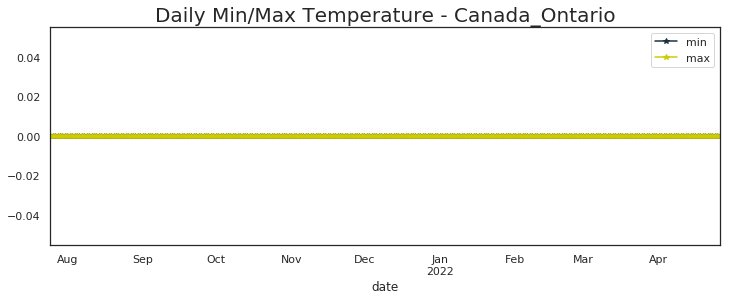

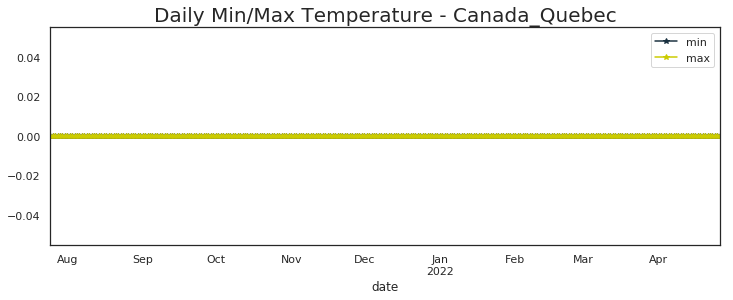

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
France_nan                  0.0  0.0
Germany_nan                 0.0  0.0
United Kingdom_nan          0.0  0.0
Russia_nan                  0.0  0.0
Korea, South_nan            0.0  0.0
Italy_nan                   0.0  0.0
Turkey_nan                  0.0  0.0
Spain_nan                   0.0  0.0
Vietnam_nan                 0.0  0.0
Argentina_nan               0.0  0.0
Netherlands_nan             0.0  0.0
Japan_nan                   0.0  0.0
Iran_nan                    0.0  0.0
Colombia_nan                0.0  0.0
Indonesia_nan               0.0  0.0
Poland_nan                  0.0  0.0
Mexico_nan                  0.0  0.0
Ukraine_nan                 0.0  0.0
Malaysia_nan                0.0  0.0
Thailand_nan                0.0  0.0
Austria_nan                 0.0  0.0
Is

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

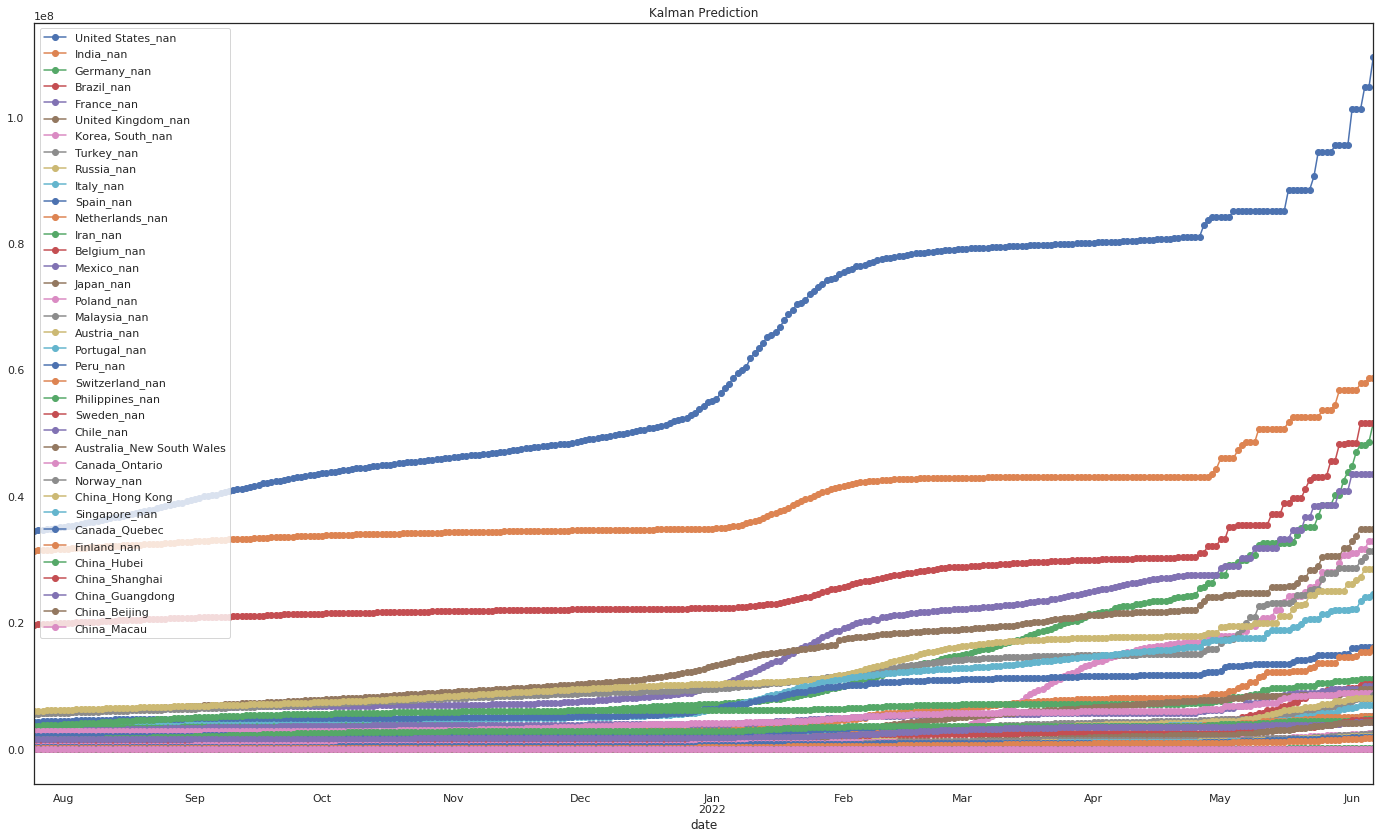

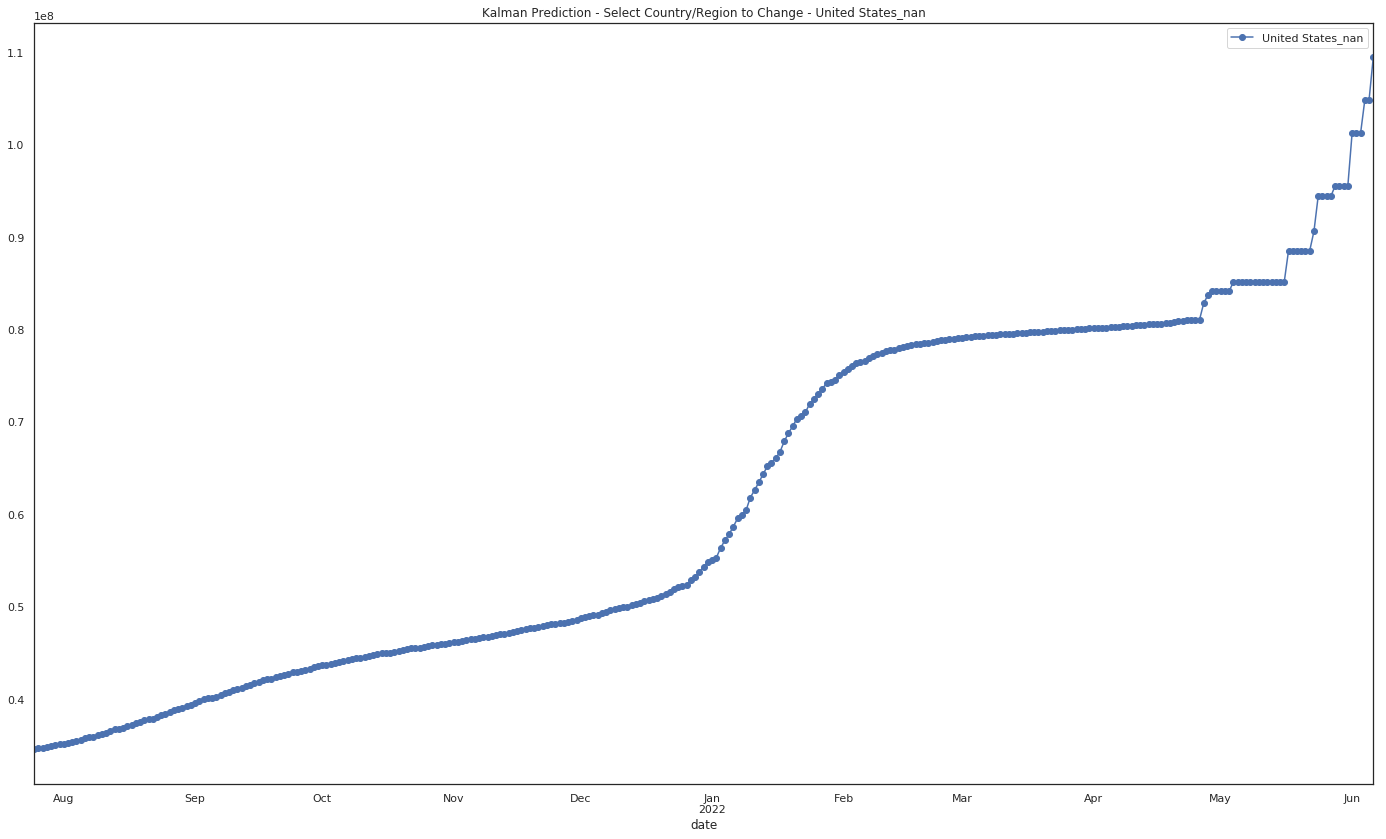

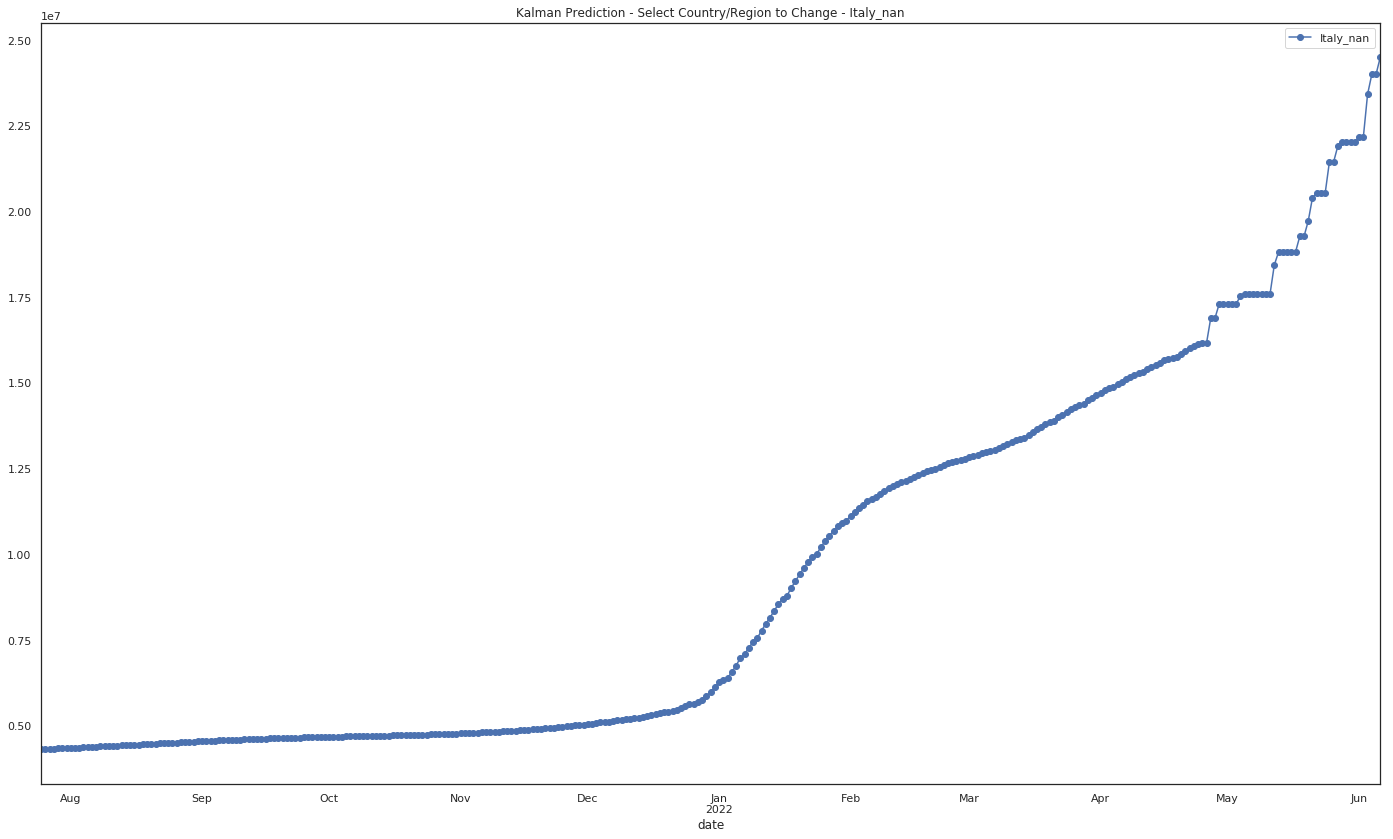

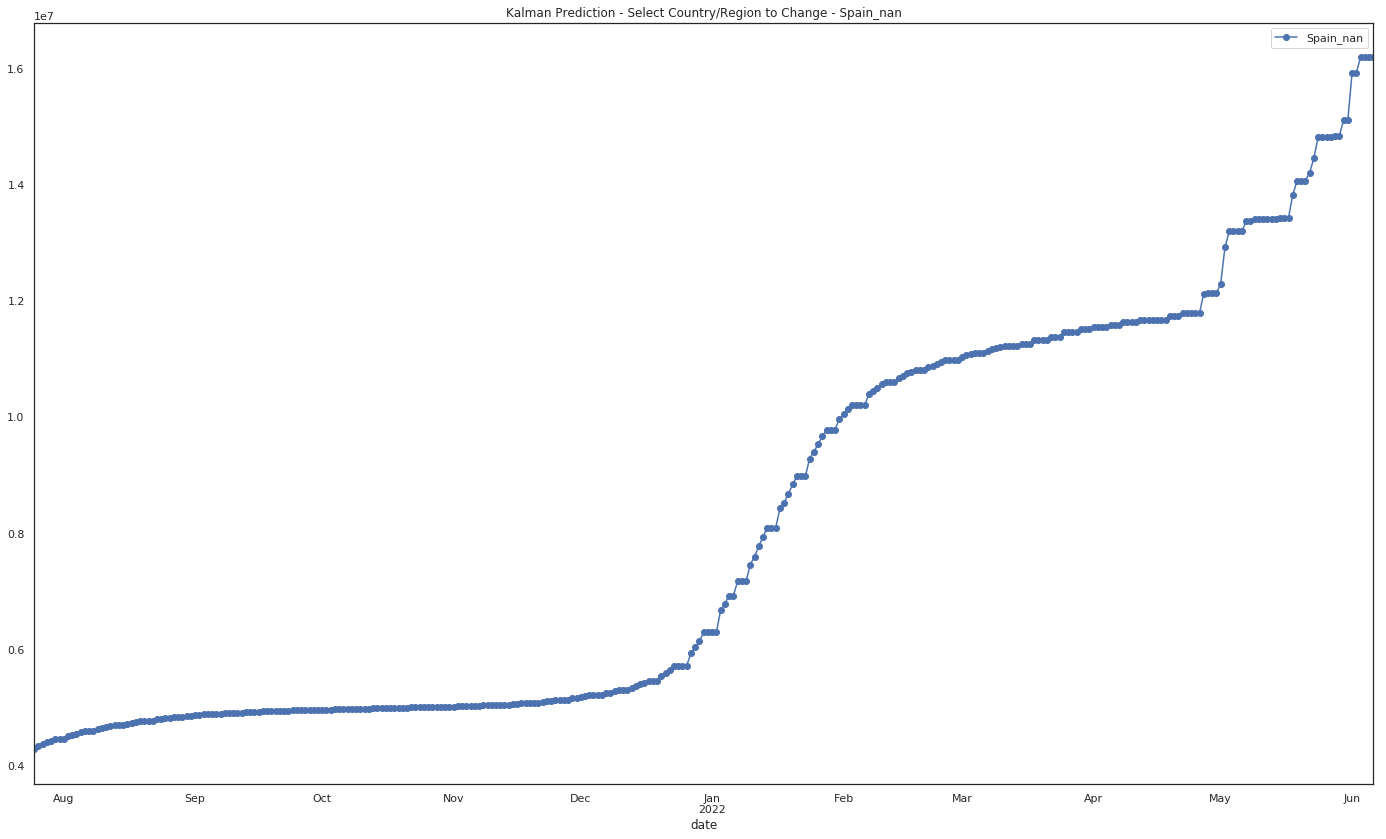

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


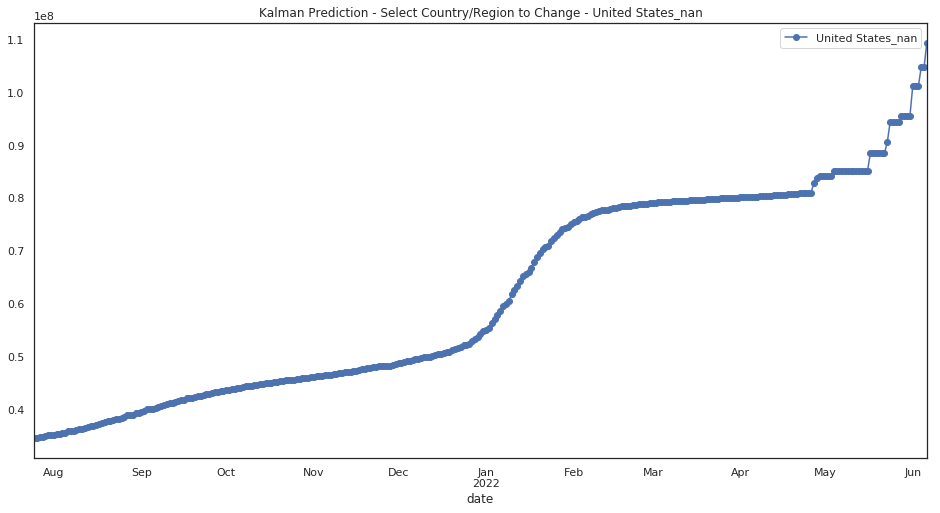

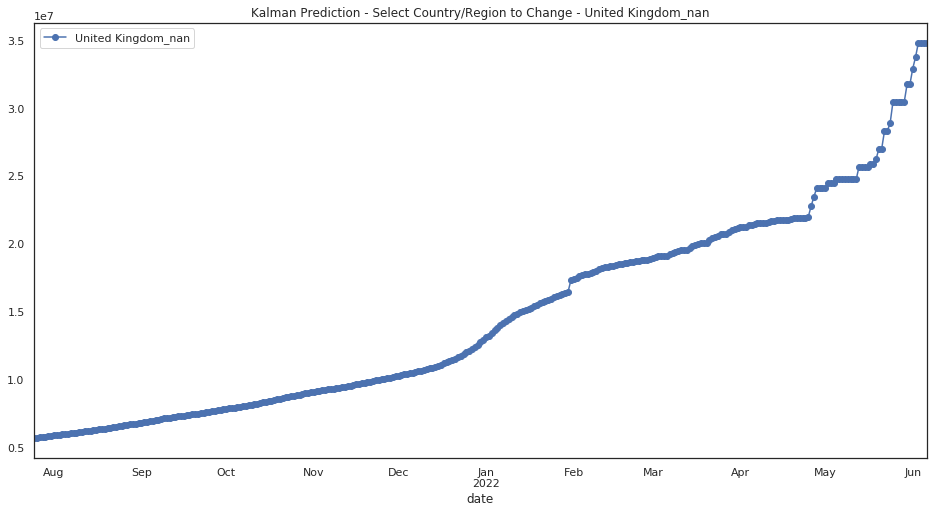

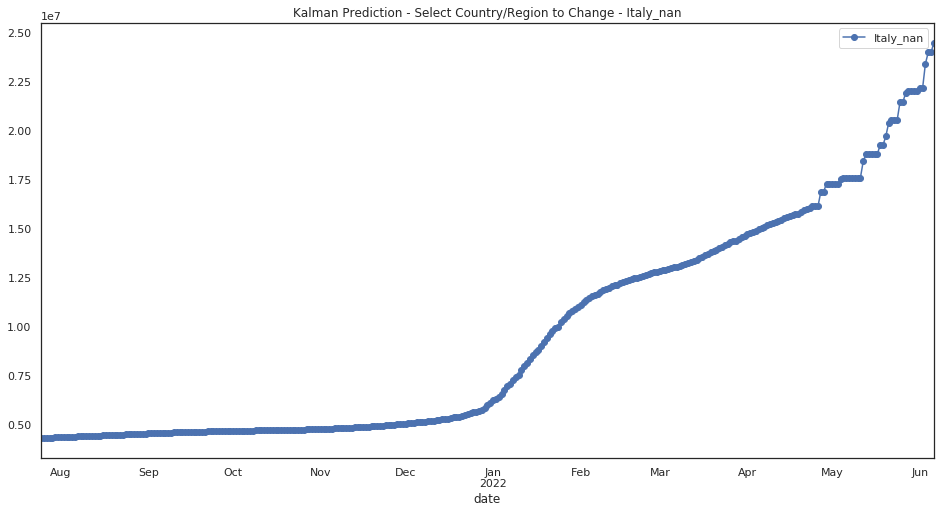

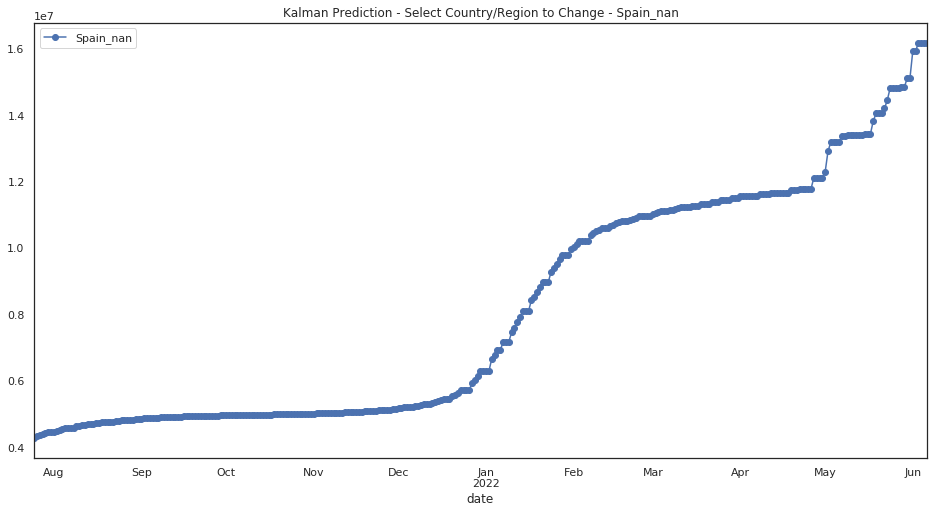

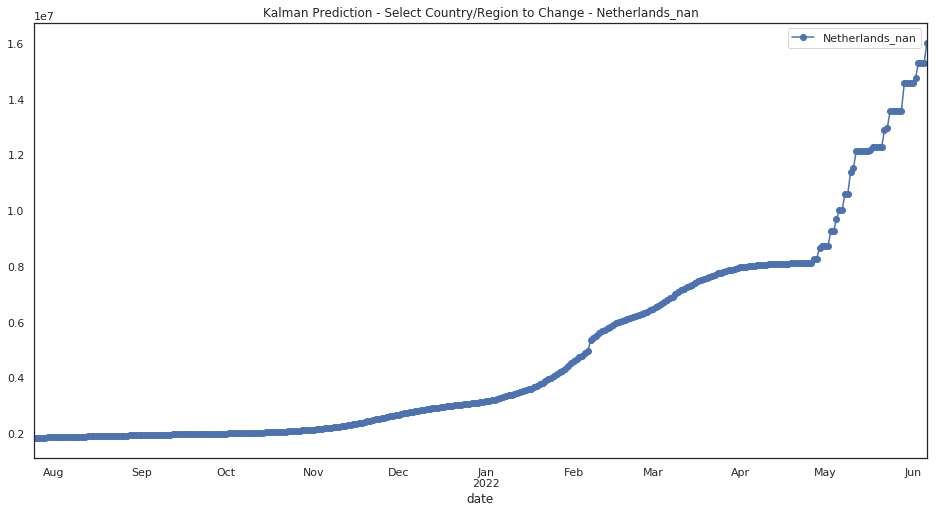

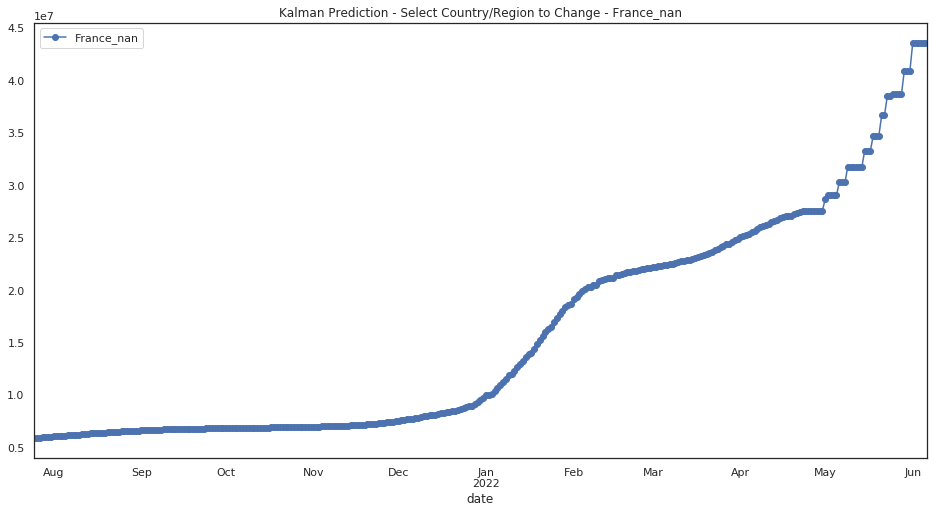

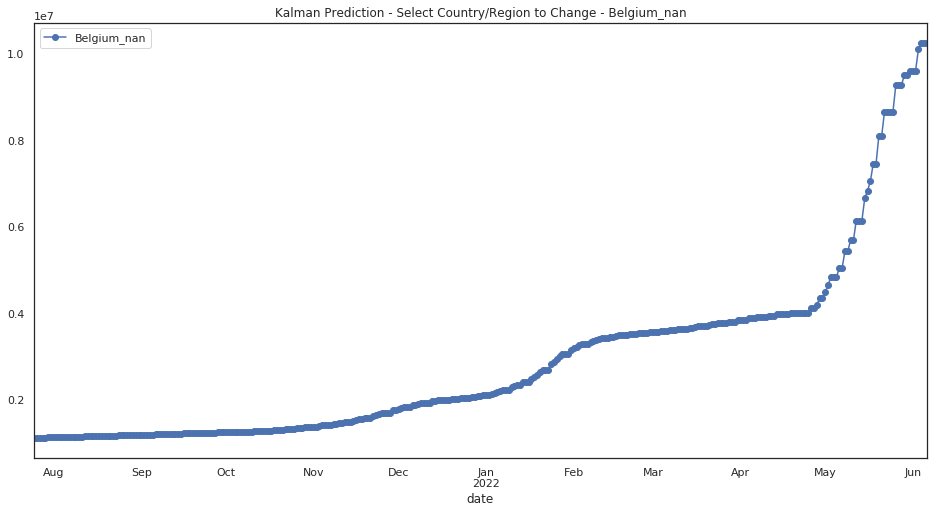

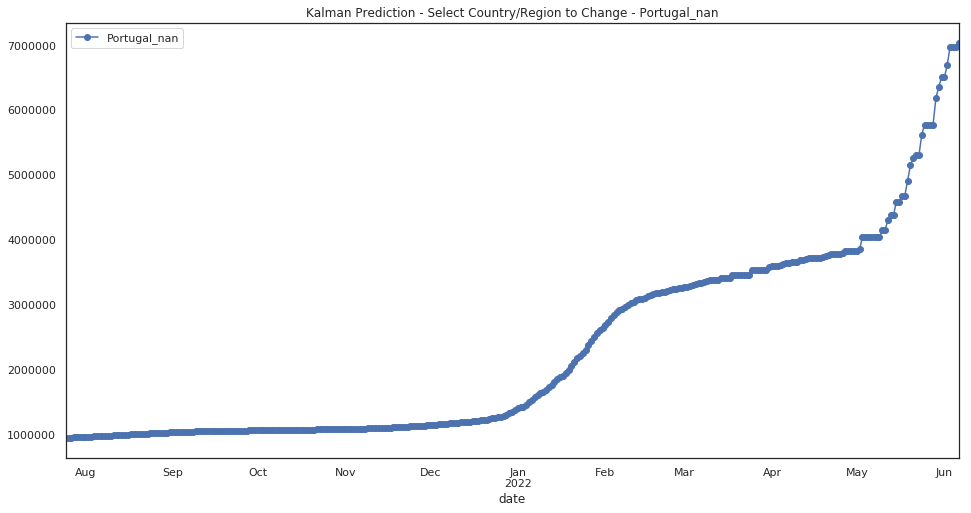

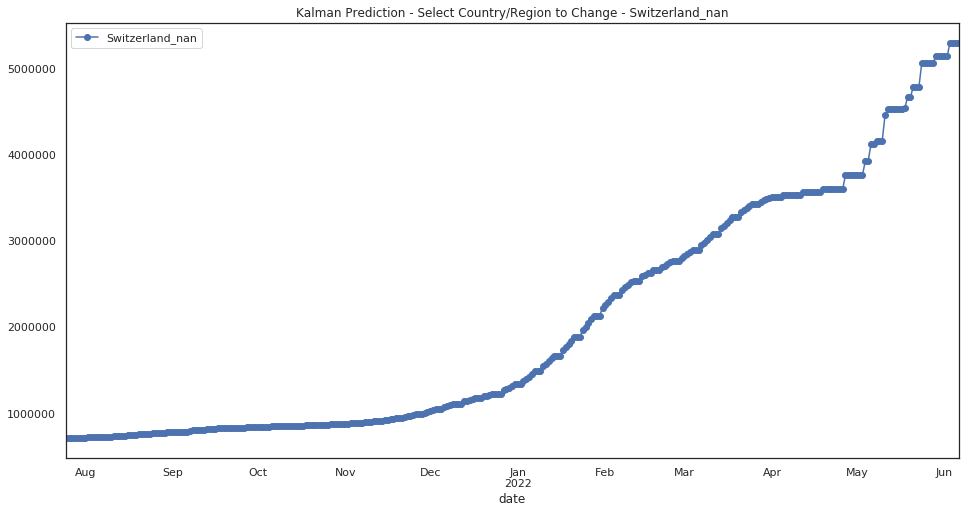

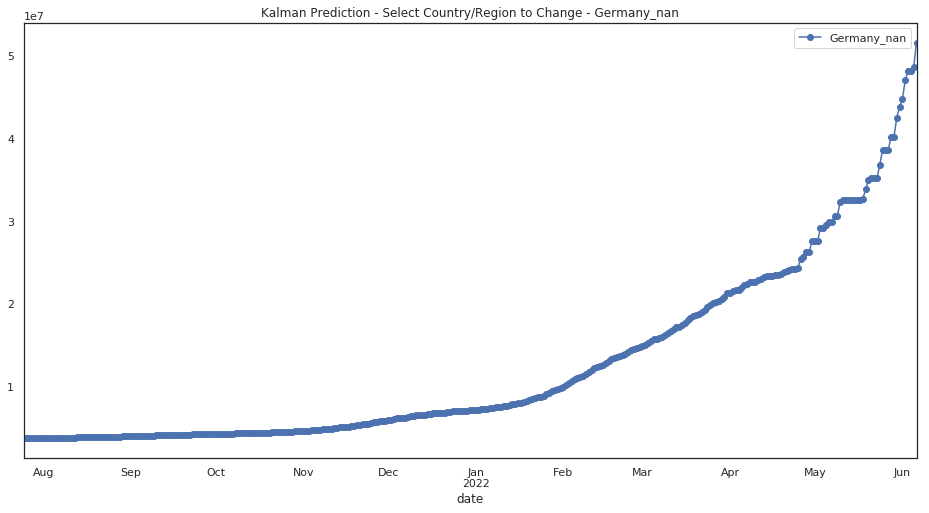

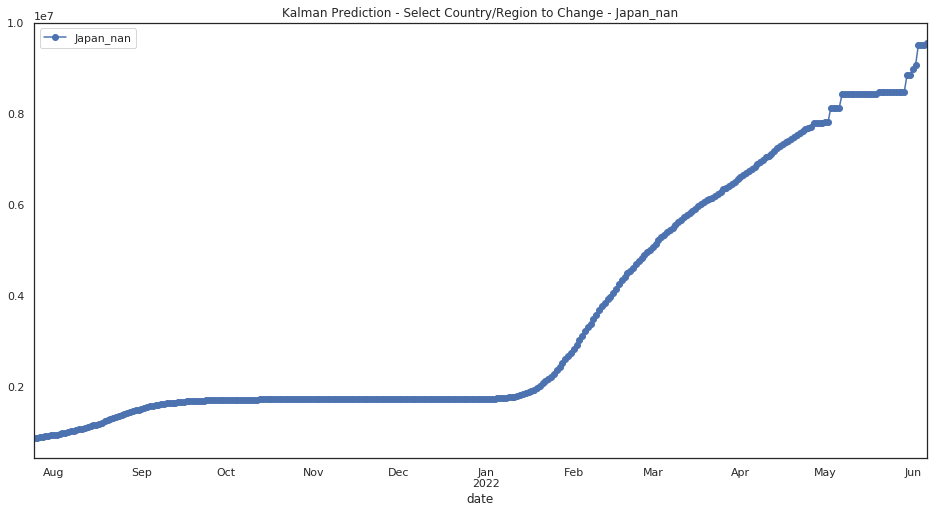

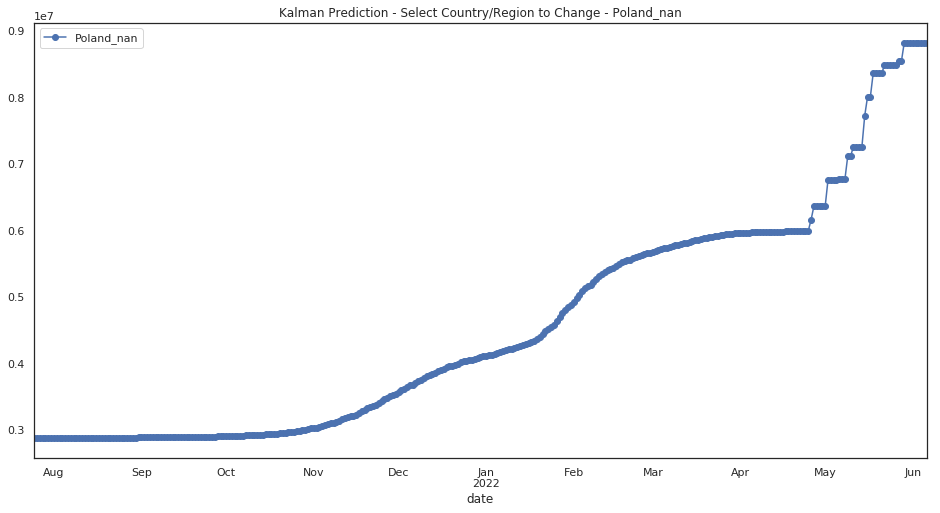

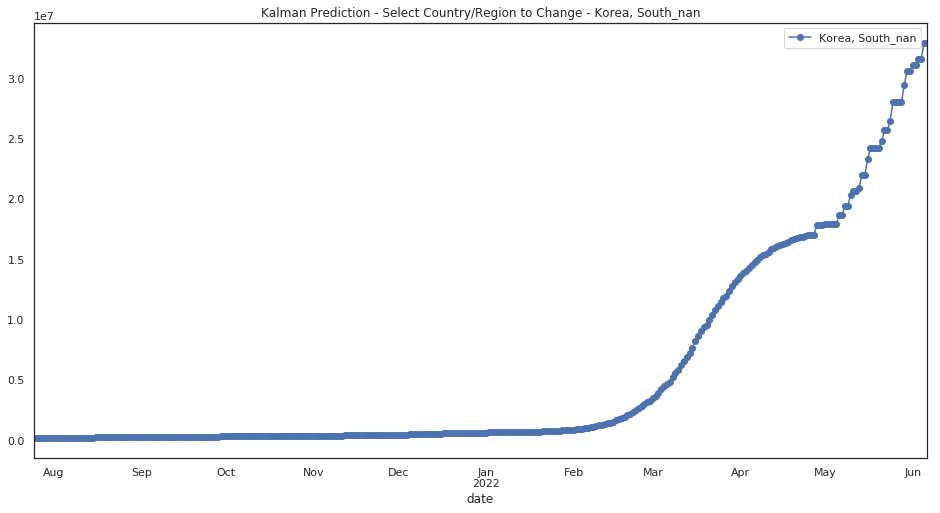

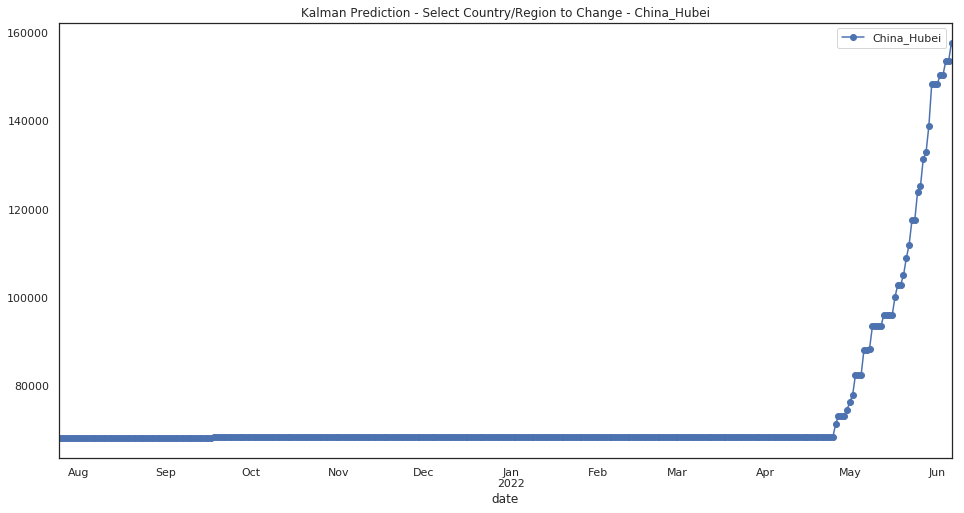

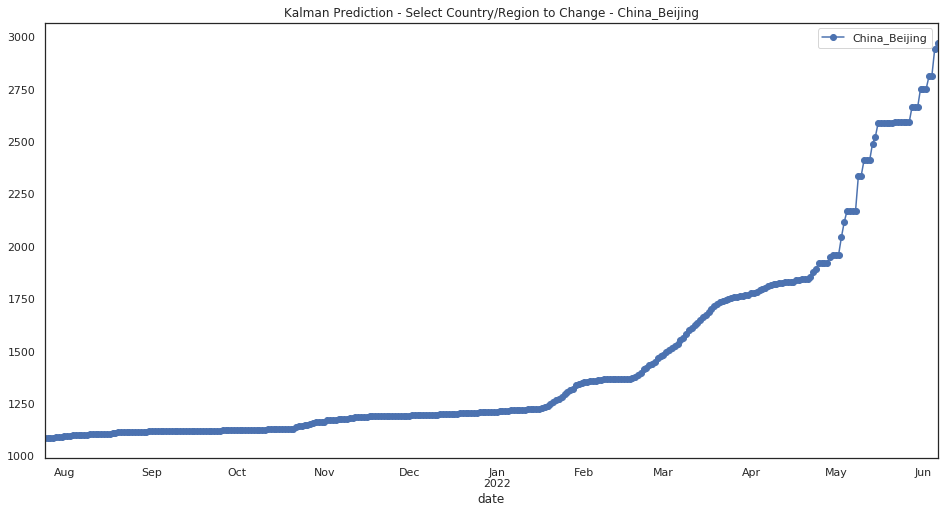

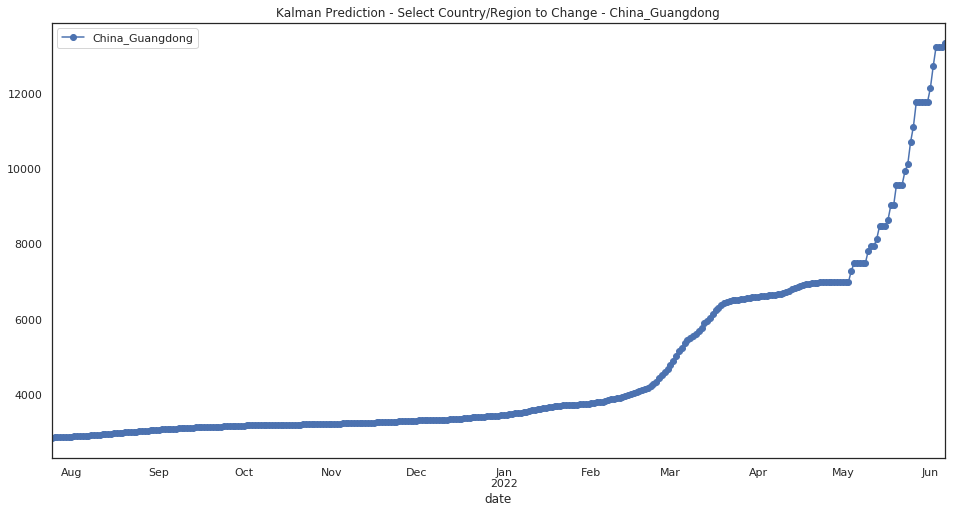

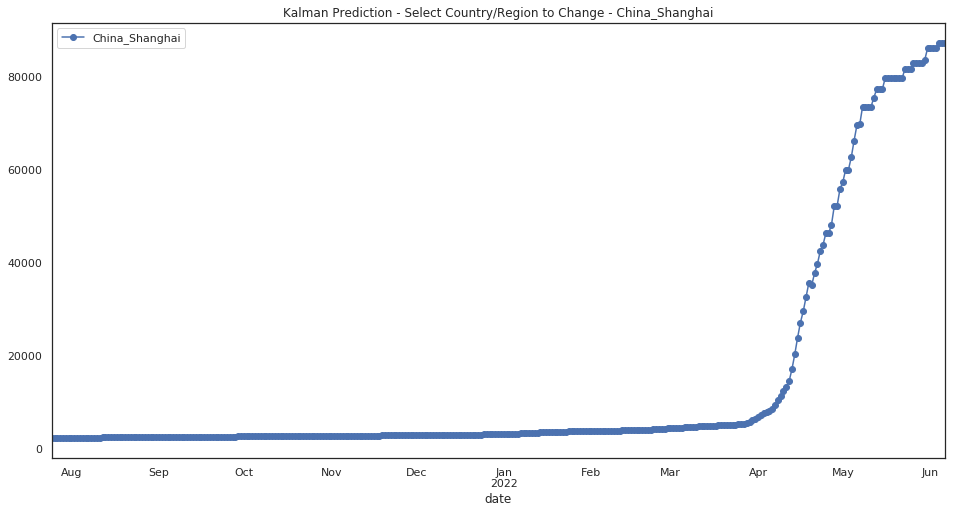

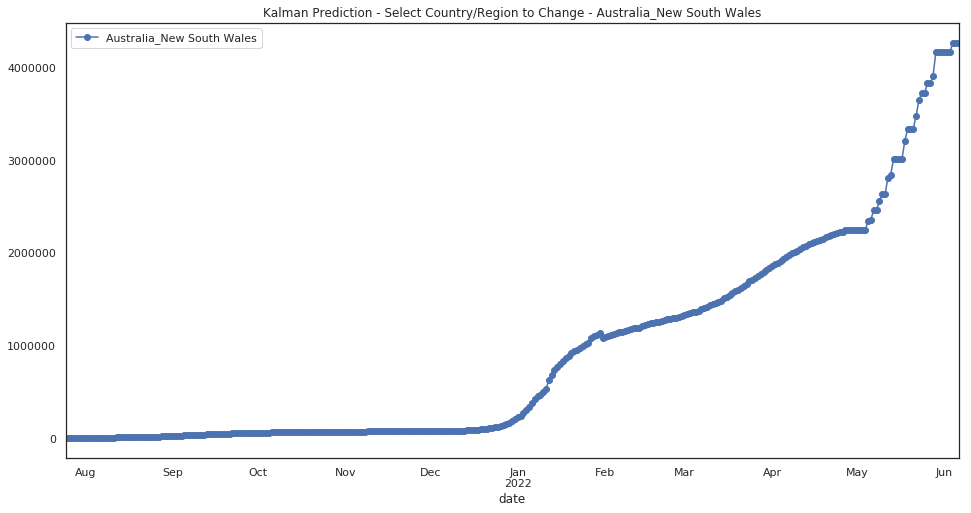

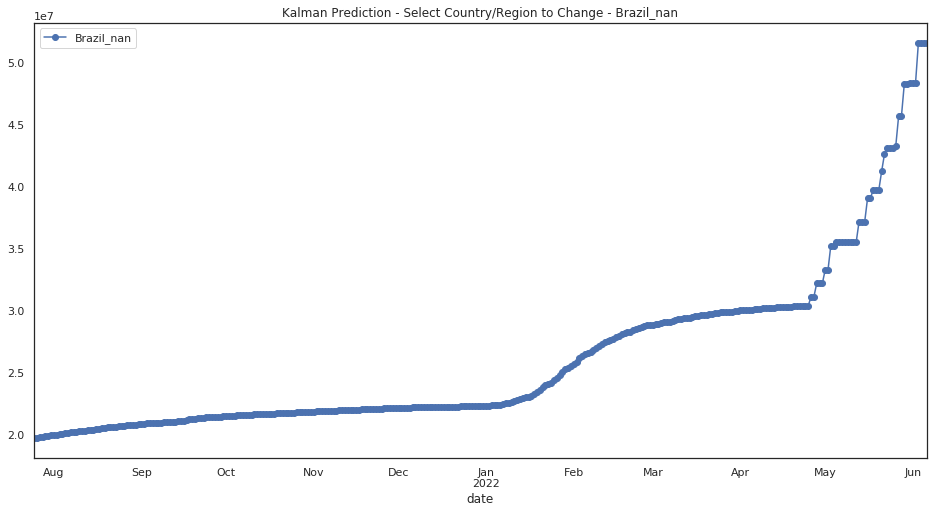

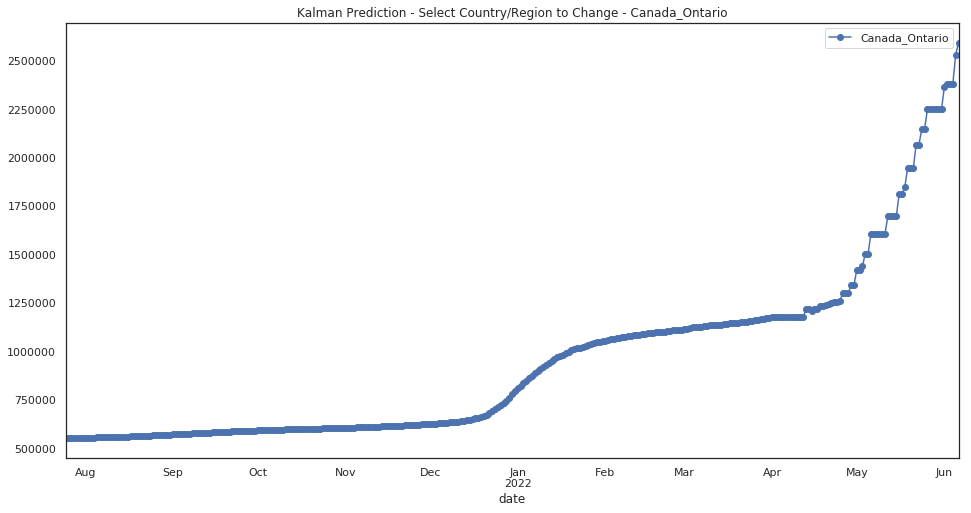

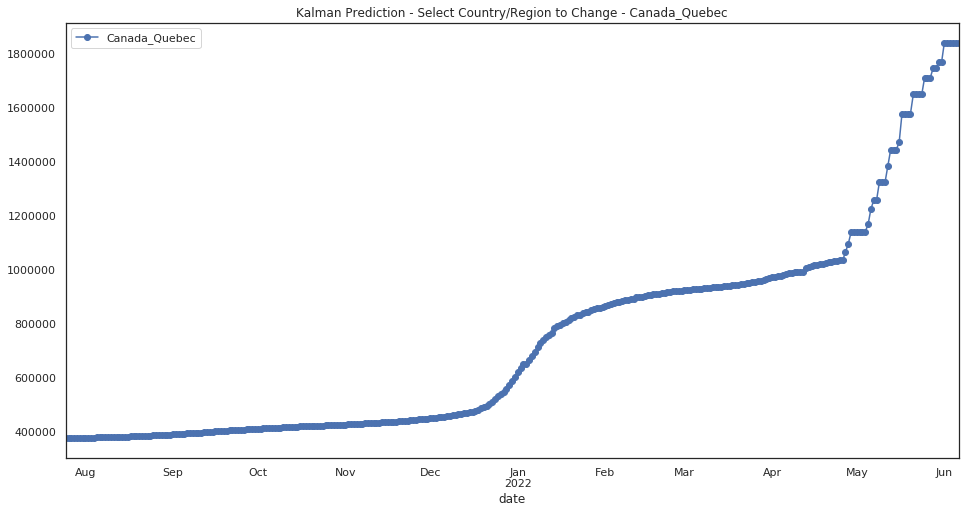

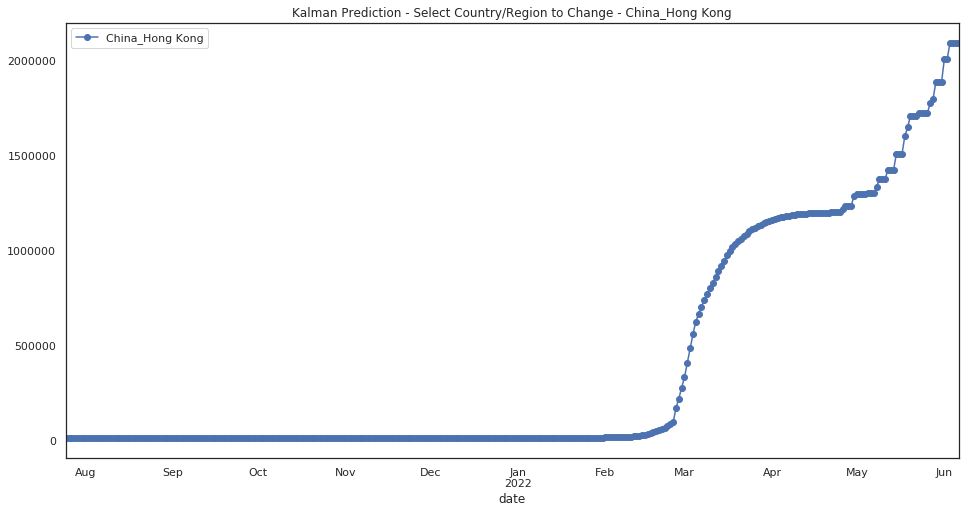

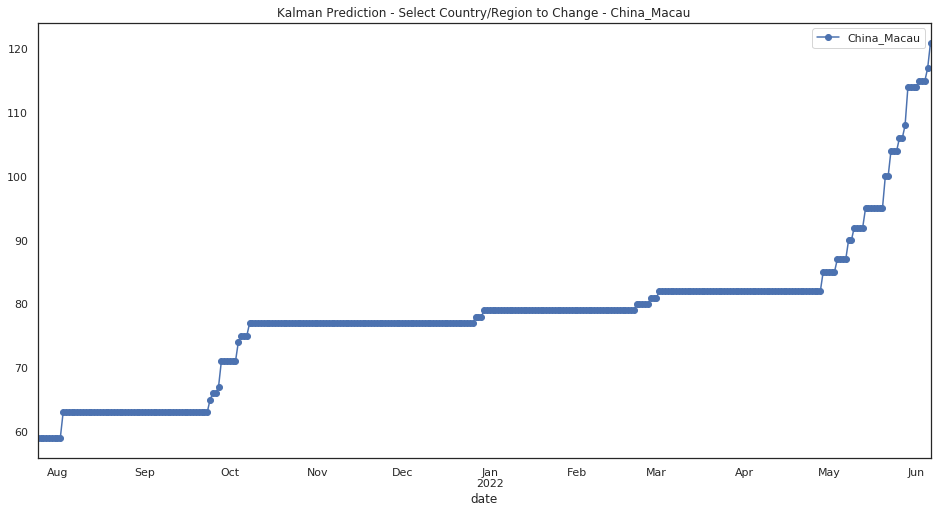

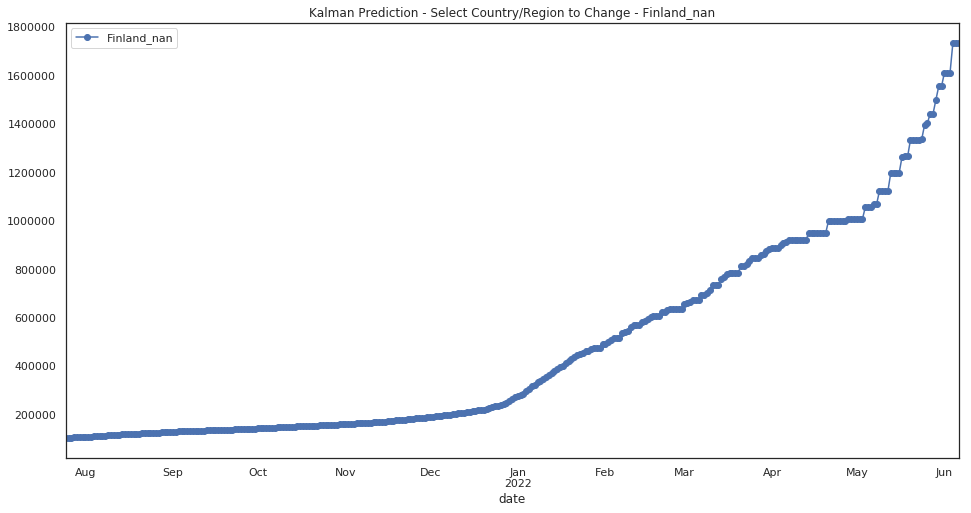

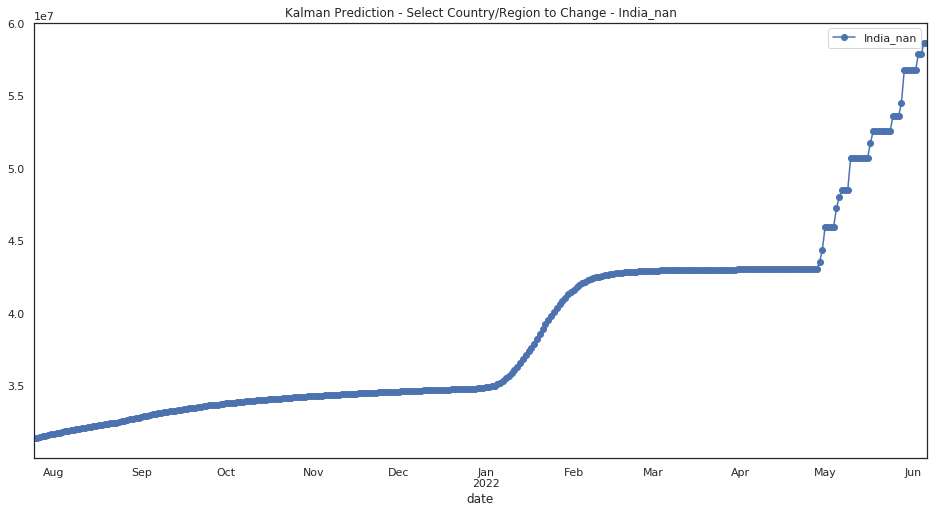

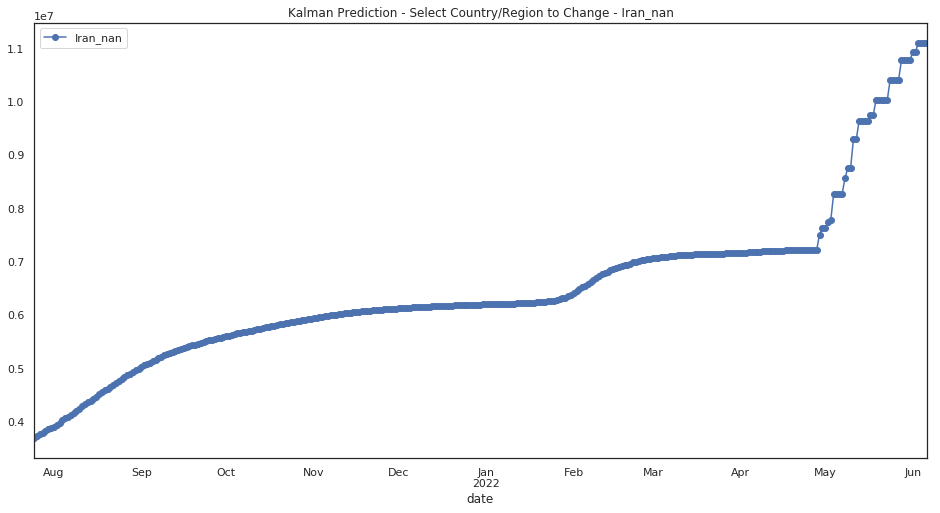

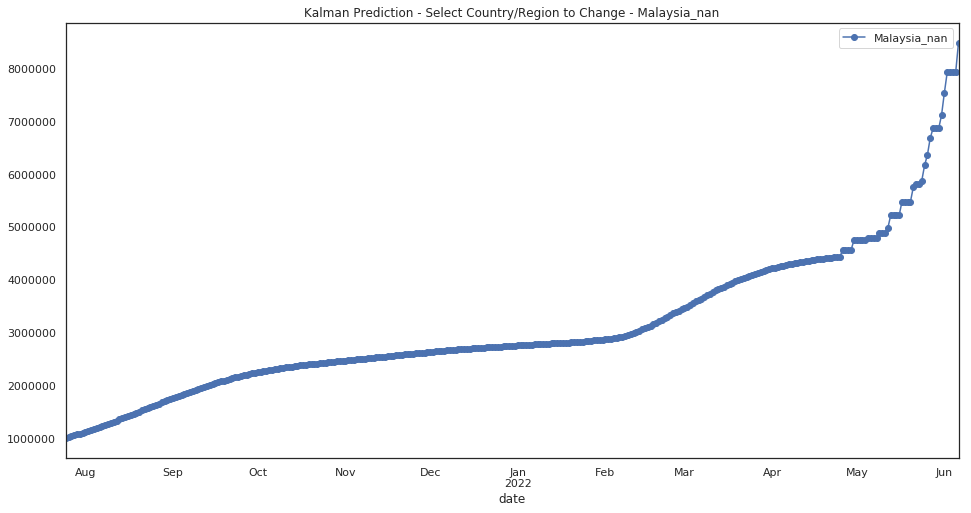

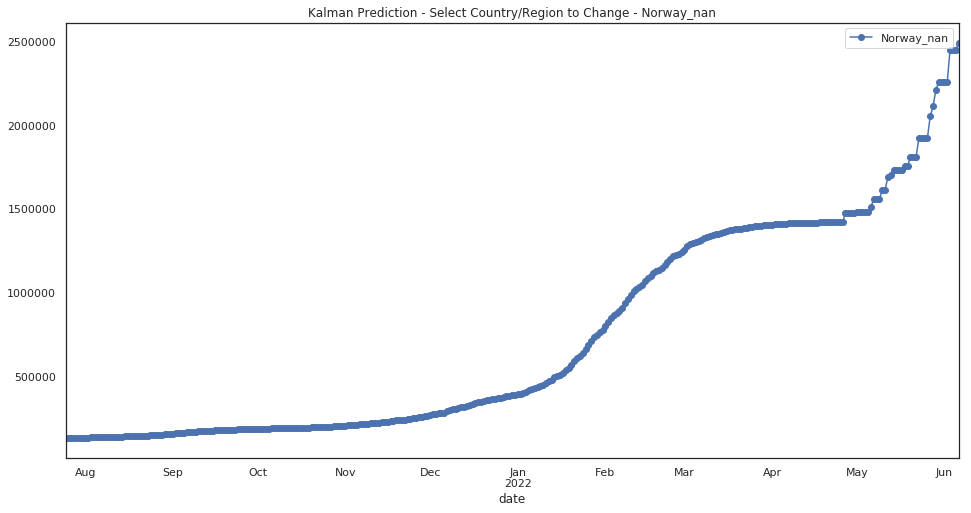

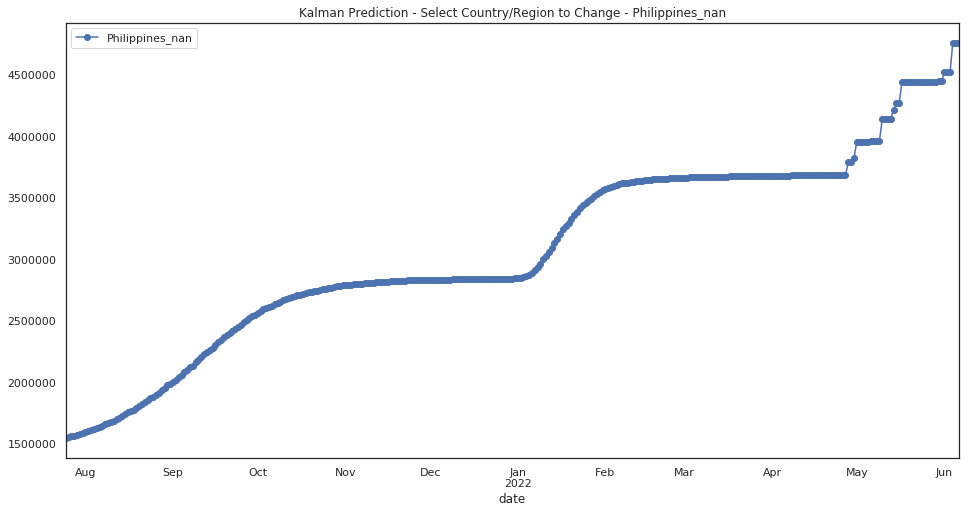

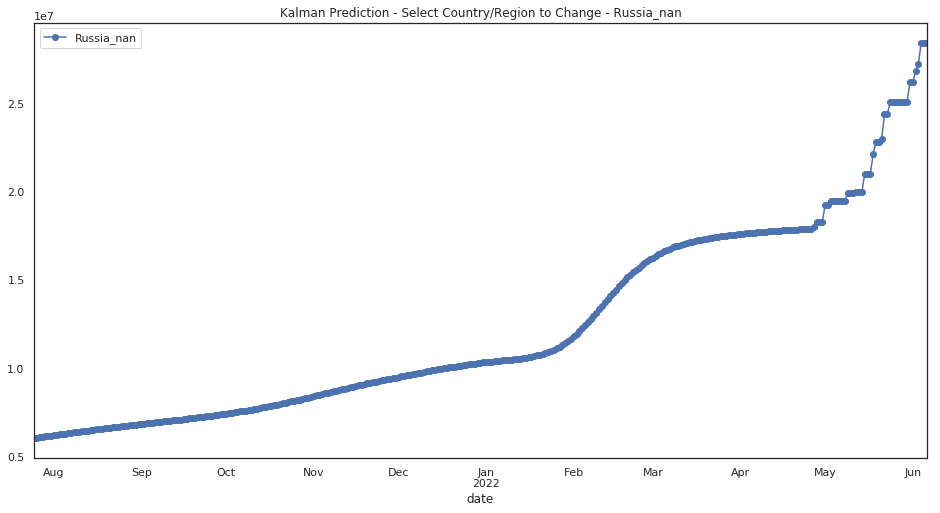

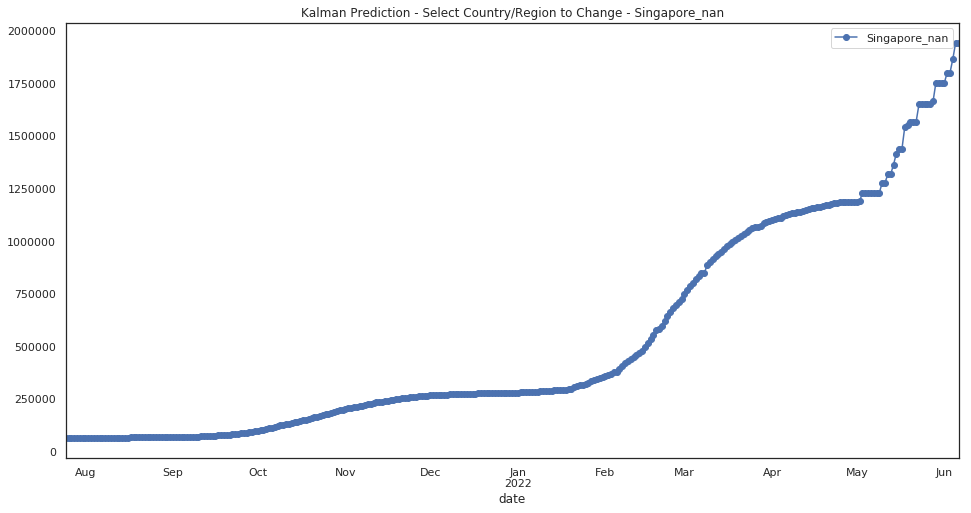

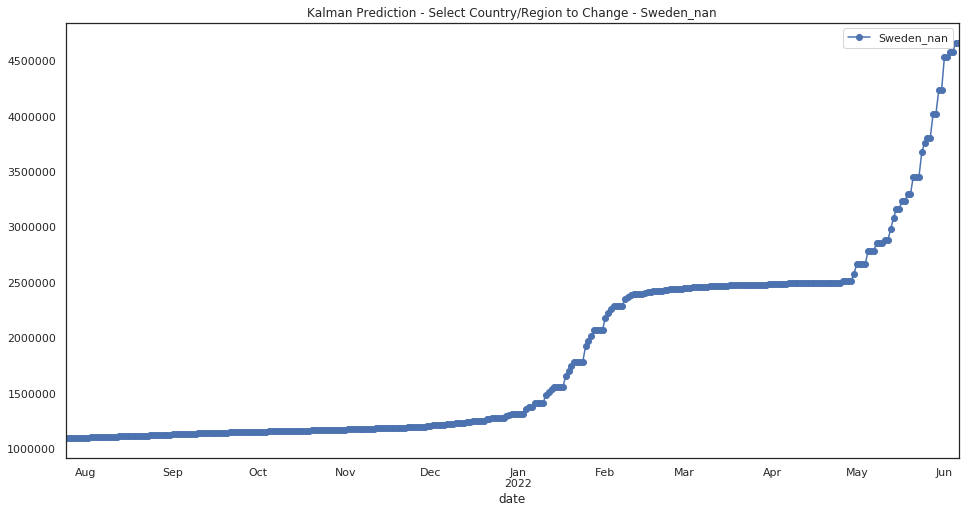

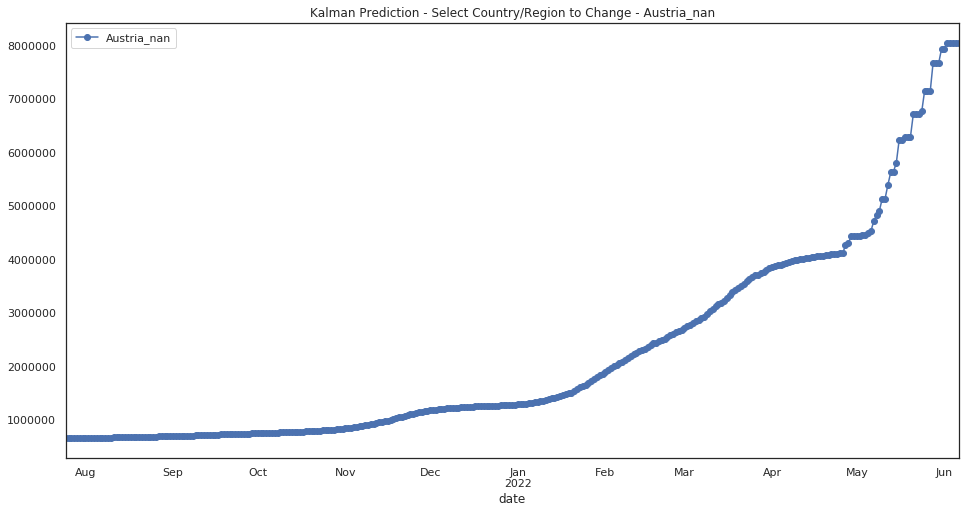

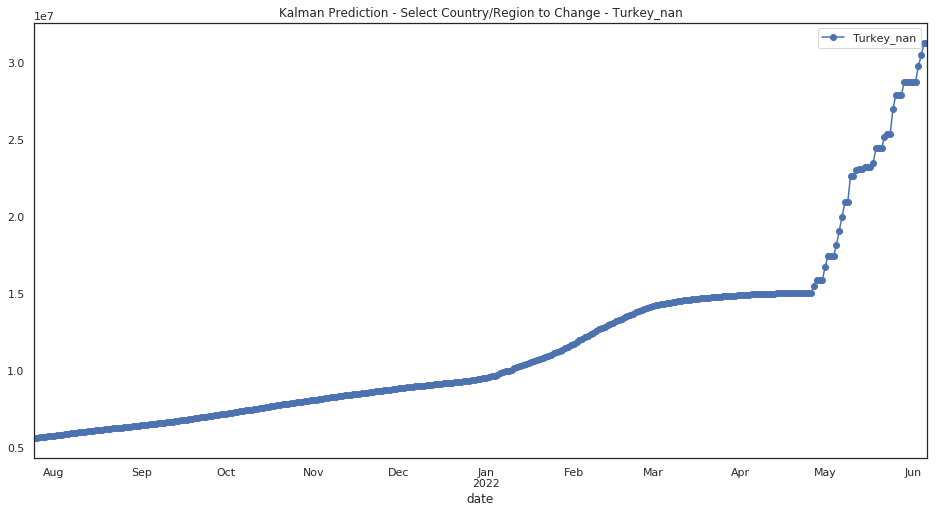

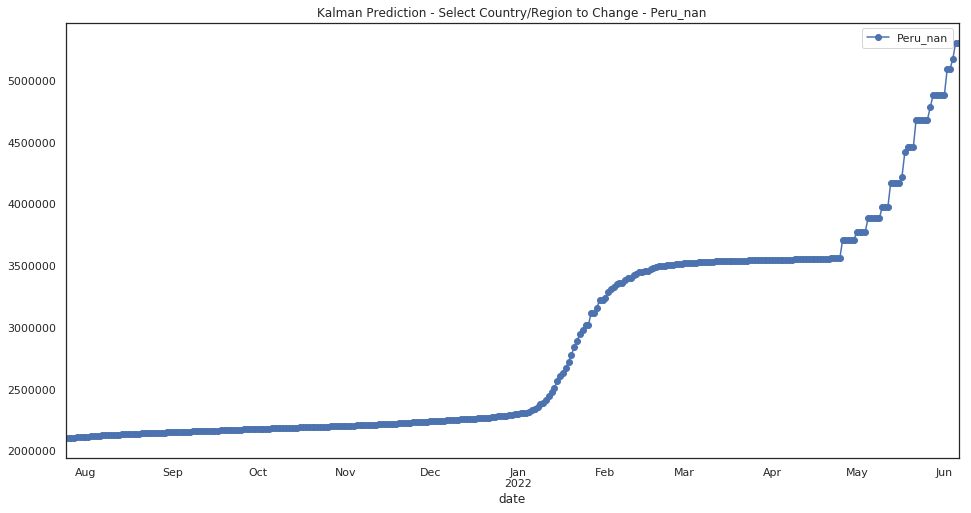

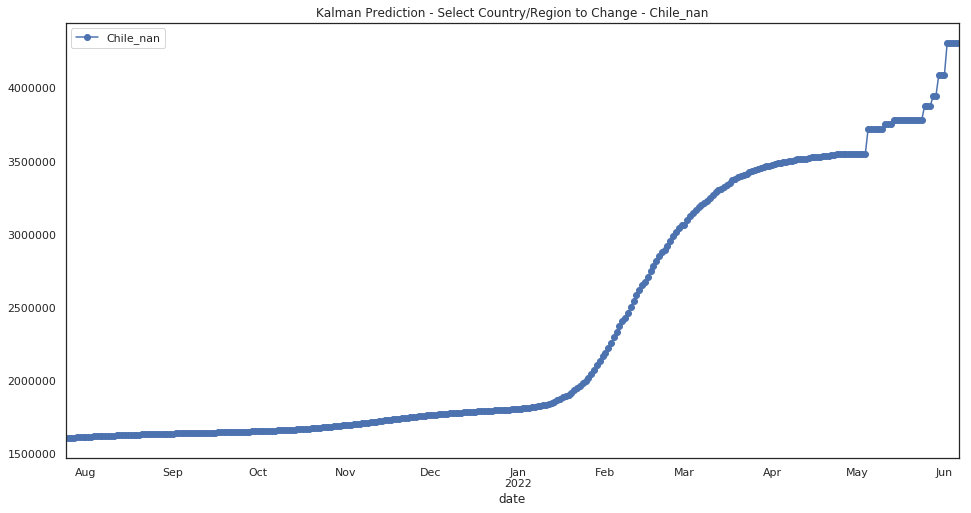

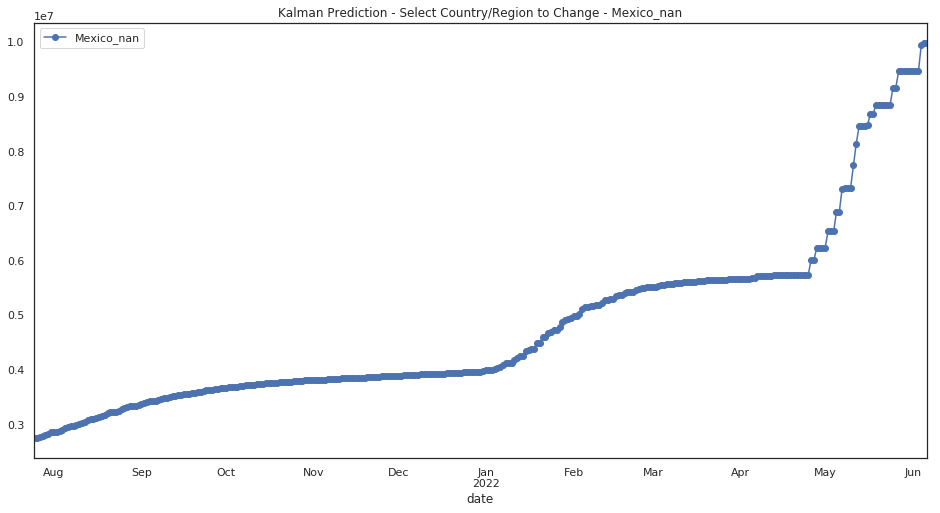

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-06-06 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN     109456546.0
India_nan                                           NaN      58670431.0
Germany_nan                                         NaN      51615493.0
Brazil_nan                                          NaN      51577157.0
France_nan                                          NaN      43593090.0
United Kingdom_nan                                  NaN      34834043.0
Korea, South_nan                                    NaN      32982123.0
Turkey_nan                                          NaN      31273298.0
Russia_nan                                          NaN      28432789.0
Italy_nan                                           NaN      24501862.0
Vietnam_nan                                         NaN      17504653.0
Spain_nan                                           NaN      16186476.0
Netherlands_nan                                     NaN      16037771.0
Argentina_nan                                       NaN      14323835.0
Iran_nan                                            NaN      11104074.0
Ukraine_nan                                         NaN      10588453.0
Belgium_nan                                         NaN      10263870.0
Mexico_nan                                          NaN       9991085.0
Japan_nan                                           NaN       9562315.0
Poland_nan                                          NaN       8824980.0
Colombia_nan                                        NaN       8647224.0
Malaysia_nan                                        NaN       8487727.0
Austria_nan                                         NaN       8053861.0
Czechia_nan                                         NaN       7992926.0
Thailand_nan                                        NaN       7480207.0
Indonesia_nan                                       NaN       7367976.0
Greece_nan                                          NaN       7270892.0
Portugal_nan                                        NaN       7039120.0
Israel_nan                                          NaN       6430670.0
South Africa_nan                                    NaN       6135074.0
...                                                 ...             ...
China_Liaoning                                      NaN          2243.0
China_Hunan                                         NaN          2046.0
China_Jiangxi                                       NaN          1995.0
China_Anhui                                         NaN          1807.0
China_Xinjiang                                      NaN          1204.0
Diamond Princess_nan                                NaN          1174.0
China_Chongqing                                     NaN          1154.0
Summer Olympics 2020_nan                            NaN          1131.0
China_Gansu                                         NaN          1091.0
France_Wallis and Futuna                            NaN           847.0
China_Hainan                                        NaN           777.0
Winter Olympics 2022_nan                            NaN           771.0
China_Shanxi                                        NaN           763.0
United Kingdom_Montserrat                           NaN           362.0
United Kingdom_Falkland Islands (Malvinas)          NaN           326.0
China_Guizhou                                       NaN           302.0
China_Ningxia                                       NaN           218.0
China_Qinghai                                       NaN           132.0
China_Macau                                         NaN           121.0
Marshall Islands_nan                                NaN            35.0
Holy See_nan                                        NaN            34.0
Canada_Repatriated Travellers                       NaN            27.0
Antarctica_nan                                      NaN            22.0
Canada_Grand Princess                               NaN            19.0
MS Zaandam_nan        

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-07-25         209560.0     200124.0     225249.0      98545.0   
2021-07-26         209915.0     200138.0     226541.0      98613.0   
2021-07-27         144285.0     132891.0     163660.0      14577.0   
2021-07-28         145008.0     132922.0     165204.0      14586.0   
2021-07-29         145552.0     132952.0     168074.0      14586.0   
2021-07-30         145996.0     132999.0     169577.0      14655.0   
2021-07-31         146523.0     133036.0     170829.0      14678.0   
2021-08-01         147154.0     133081.0     171956.0      14678.0   
2021-08-02         149459.0     134501.0     175052.0      15065.0   
2021-08-03         150027.0     134560.0     176389.0      14747.0   
2021-08-04         150427.0     134651.0     177873.0      15024.0   
2021-08-05         150855.0     134774.0     179250.0      14981.0   
2021-08-06         151300.0     134919.0     180458.0      15089.0   
2021-08-07         151733.0     135055.0     181615.0      15010.0   
2021-08-08         151995.0     135228.0     182638.0      15150.0   
2021-08-09         152296.0     135304.0     183621.0      15147.0   
2021-08-10         152549.0     135503.0     184614.0      15165.0   
2021-08-11         152832.0     135766.0     185491.0      14991.0   
2021-08-12         153113.0     136032.0     186357.0      15114.0   
2021-08-13         153336.0     136397.0     187238.0      15139.0   
2021-08-14         153523.0     136790.0     188025.0      15139.0   
2021-08-15         153636.0     137177.0     188655.0      15221.0   
2021-08-16         153741.0     137399.0     189347.0      15242.0   
2021-08-17         153851.0     137808.0     190070.0      15092.0   
2021-08-18         153973.0     138258.0     190801.0      15235.0   
2021-08-19         154042.0     138765.0     191514.0      15190.0   
2021-08-20         154089.0     139296.0     192114.0      15248.0   
2021-08-21         154144.0     139930.0     192635.0      15237.0   
2021-08-22         154167.0     140470.0     193060.0      15271.0   
2021-08-23         154233.0     140884.0     193540.0      15282.0   
...                     ...          ...          ...          ...   
2022-05-09         192048.0     346088.0     285067.0      44809.0   
2022-05-10         192060.0     352641.0     285067.0      44809.0   
2022-05-11         192216.0     355133.0     288800.0      46315.0   
2022-05-12         192216.0     377971.0     290570.0      46315.0   
2022-05-13         194978.0     383660.0     299598.0      47554.0   
2022-05-14         195825.0     394530.0     304560.0      48646.0   
2022-05-15         200908.0     413956.0     303615.0      50918.0   
2022-05-16         206195.0     416239.0     305042.0      50918.0   
2022-05-17         206341.0     435955.0     303644.0      50918.0   
2022-05-18         205619.0     467180.0     303644.0      50918.0   
2022-05-19         205417.0     472856.0     315595.0      50918.0   
2022-05-20         216751.0     466883.0     321440.0      52530.0   
2022-05-21         220850.0     466883.0     320008.0      52530.0   
2022-05-22         218447.0     466883.0     321152.0      55527.0   
2022-05-23         222121.0     469974.0     320139.0      56549.0   
2022-05-24         223179.0     469974.0     320139.0      56549.0   
2022-05-25         232175.0     494775.0     329418.0      56549.0   
2022-05-26         243132.0     522686.0     334217.0      59470.0   
2022-05-27         243477.0     532397.0     331409.0      61969.0   
2022-05-28         242300.0     545305.0     338752.0      61969.0   
2022-05-29         246991.0     566116.0     349828.0      61969.0   
2022-05-30         256451.0     578212.0     350743.0      63450.0   
2022-05-31         269730.0     570281.0     355704.0      64896.0   
2022-06-01         272407.0     592228.0     359803.0      65727.0   
2022-06-02

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Germany_nan',
 'Brazil_nan',
 'France_nan',
 'United Kingdom_nan',
 'Korea, South_nan',
 'Turkey_nan',
 'Russia_nan',
 'Italy_nan',
 'Vietnam_nan',
 'Spain_nan',
 'Netherlands_nan',
 'Argentina_nan',
 'Iran_nan',
 'Ukraine_nan',
 'Belgium_nan',
 'Mexico_nan',
 'Japan_nan',
 'Poland_nan',
 'Colombia_nan',
 'Malaysia_nan',
 'Austria_nan',
 'Czechia_nan',
 'Thailand_nan',
 'Indonesia_nan',
 'Greece_nan',
 'Portugal_nan',
 'Israel_nan',
 'South Africa_nan',
 'Peru_nan',
 'Switzerland_nan',
 'Serbia_nan',
 'Slovakia_nan',
 'Romania_nan',
 'Philippines_nan',
 'Sweden_nan',
 'Chile_nan',
 'Denmark_nan',
 'Australia_New South Wales',
 'Jordan_nan',
 'Iraq_nan',
 'Hungary_nan',
 'Bangladesh_nan',
 'Georgia_nan',
 'Ireland_nan',
 'Lithuania_nan',
 'Canada_Ontario',
 'Norway_nan',
 'Bulgaria_nan',
 'Pakistan_nan',
 'Morocco_nan',
 'Australia_Victoria',
 'China_Hong Kong',
 'Singapore_nan',
 'Slovenia_nan',
 'Belarus_nan',
 'Kazakhstan_nan',
 'Canada_Quebec',


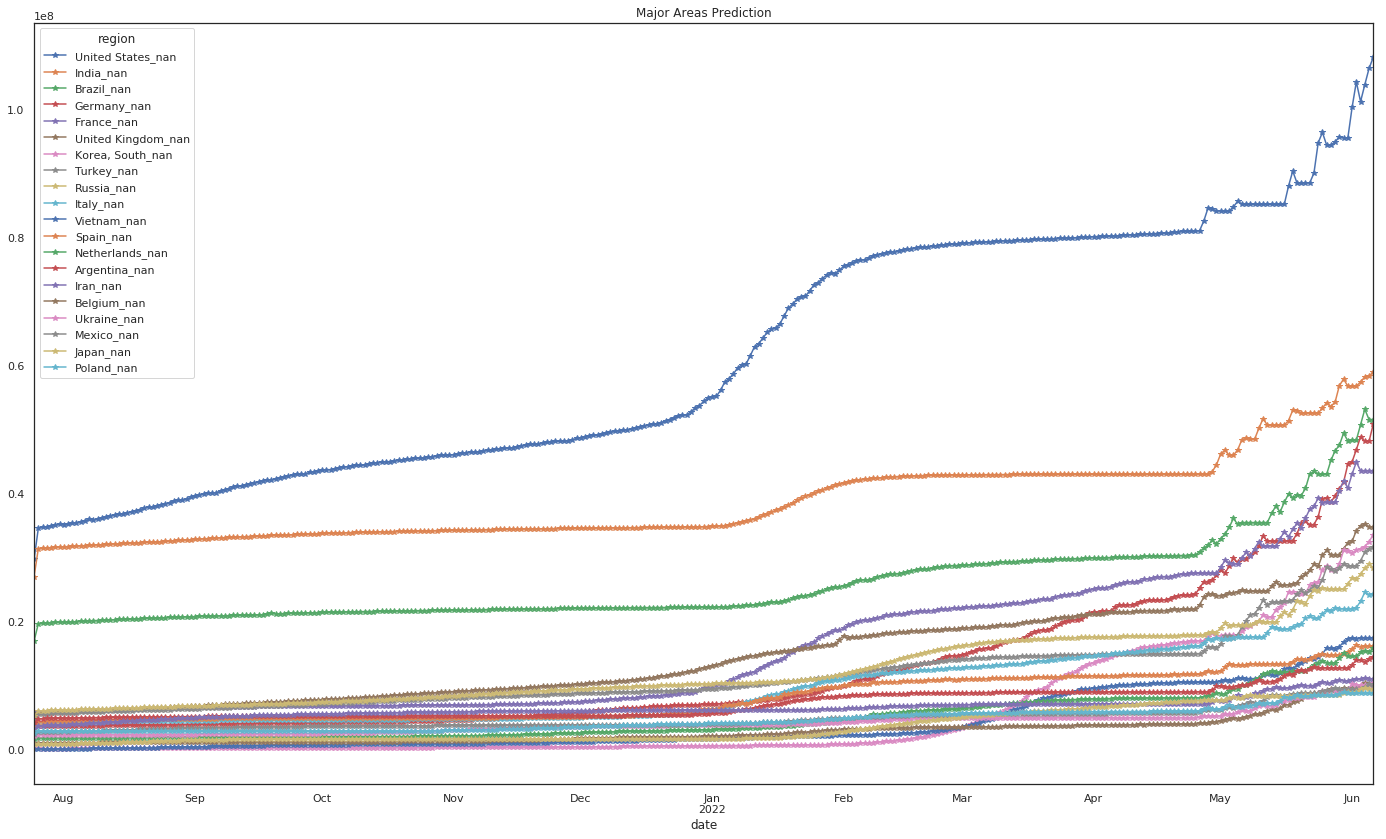

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

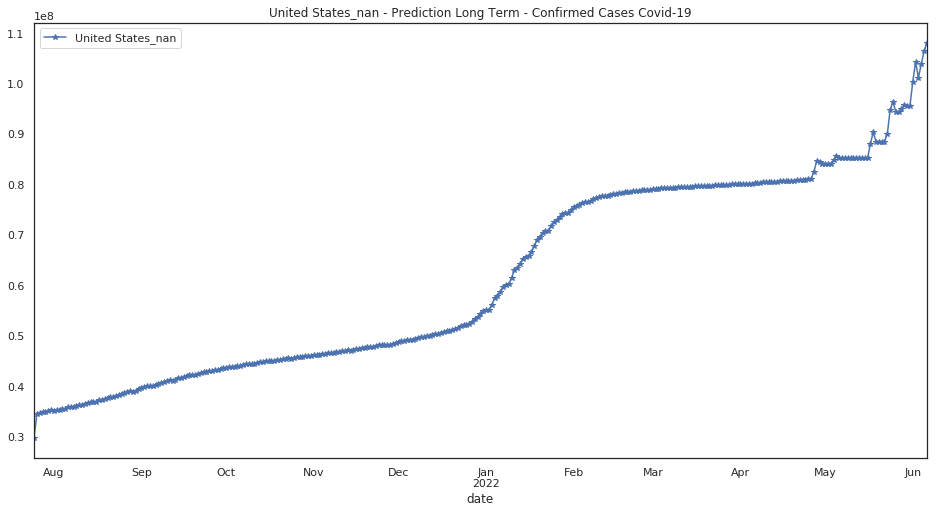

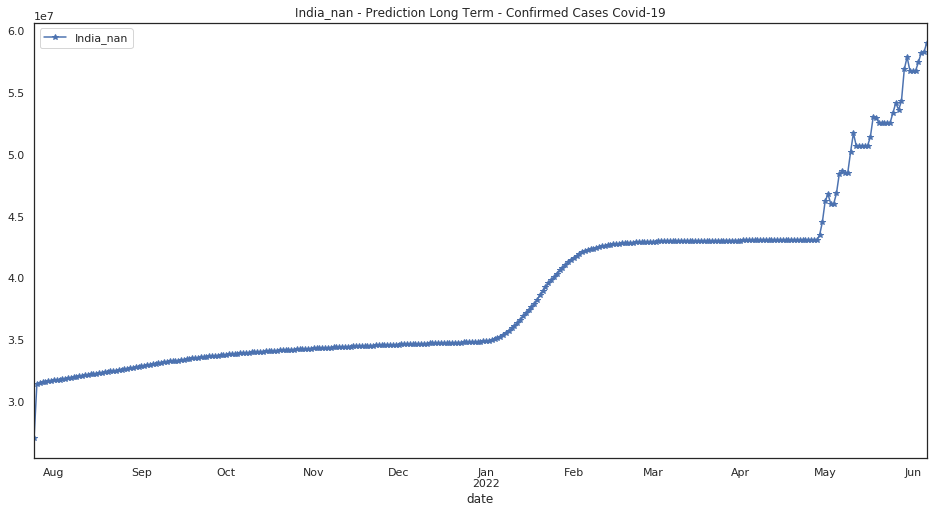

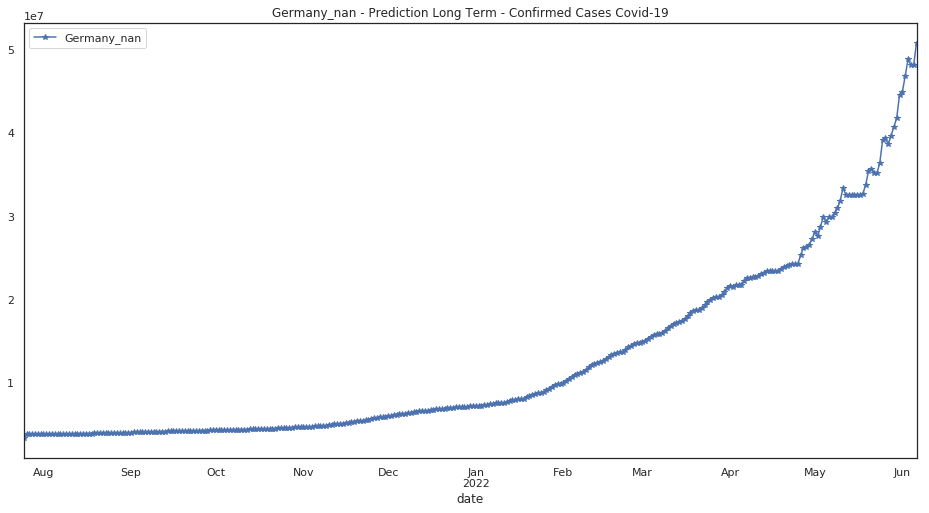

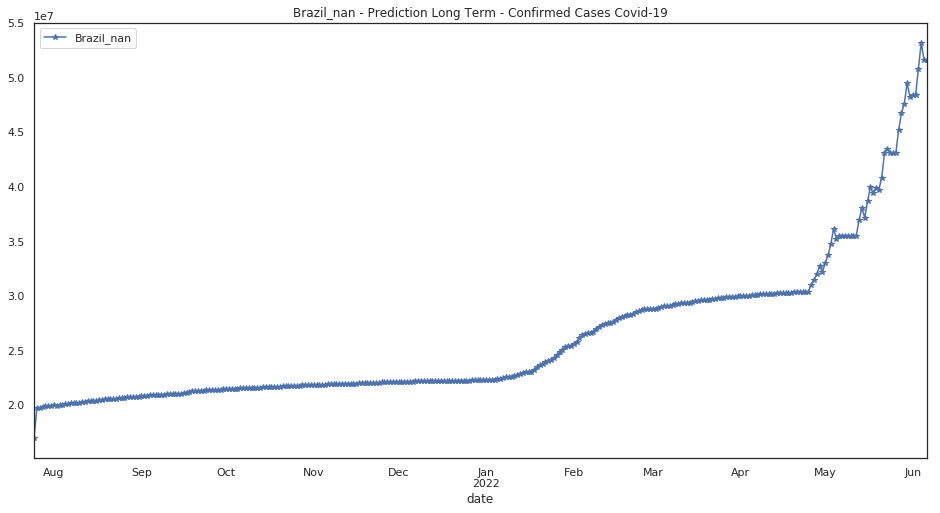

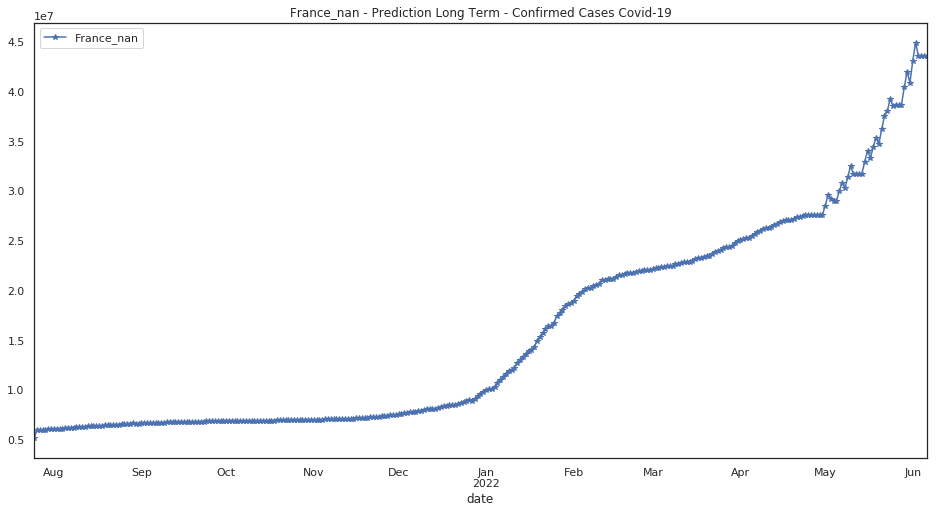

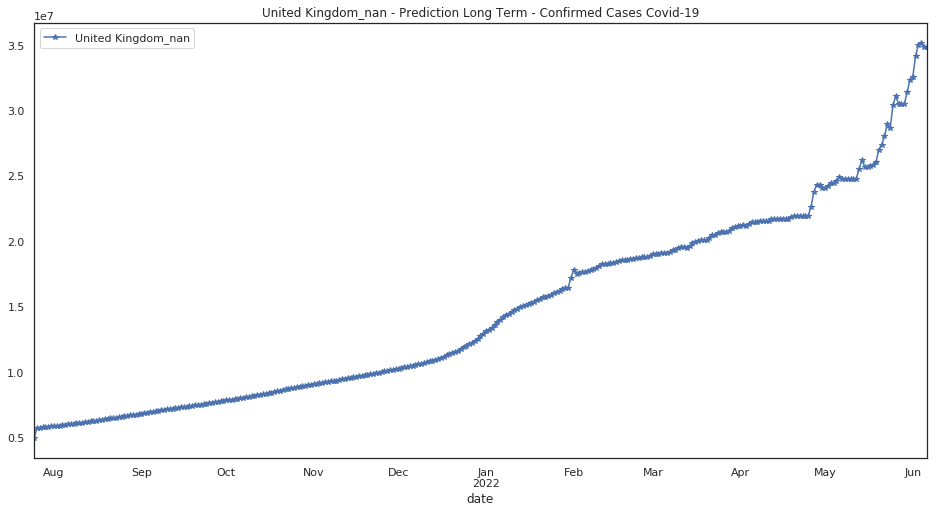

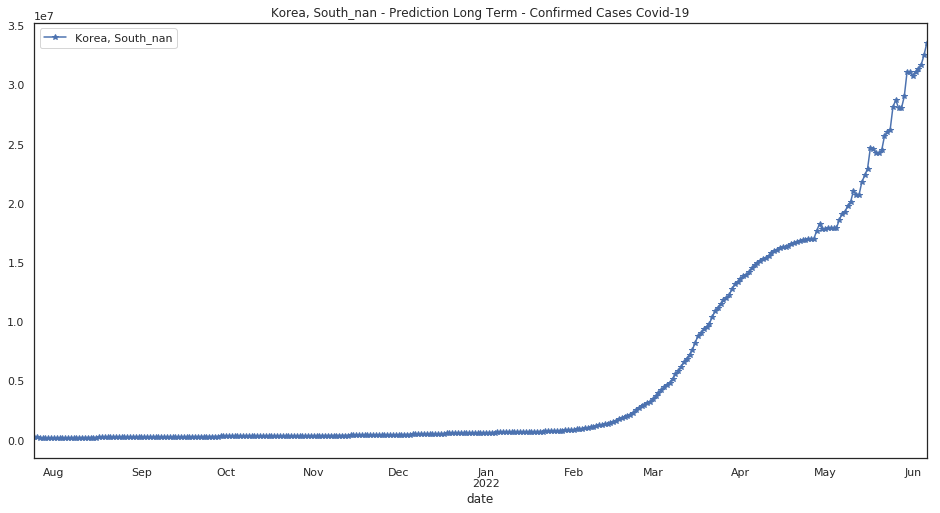

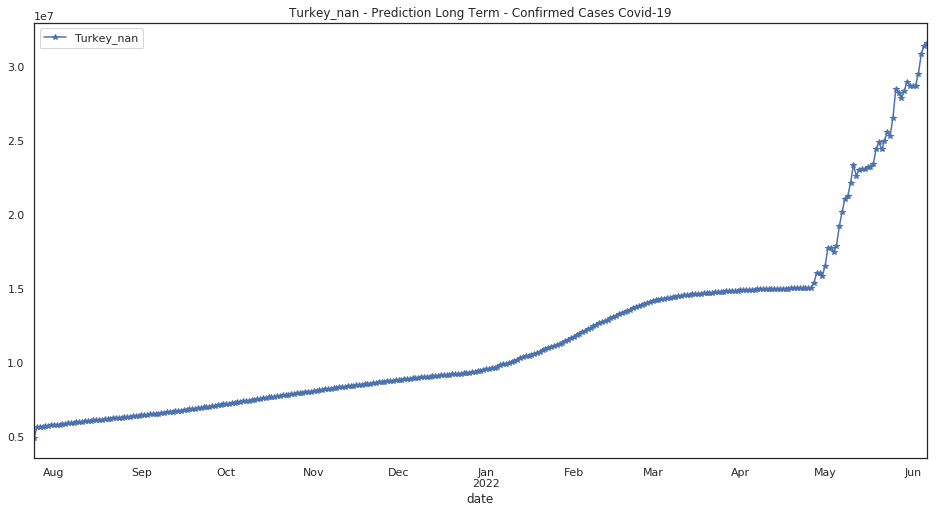

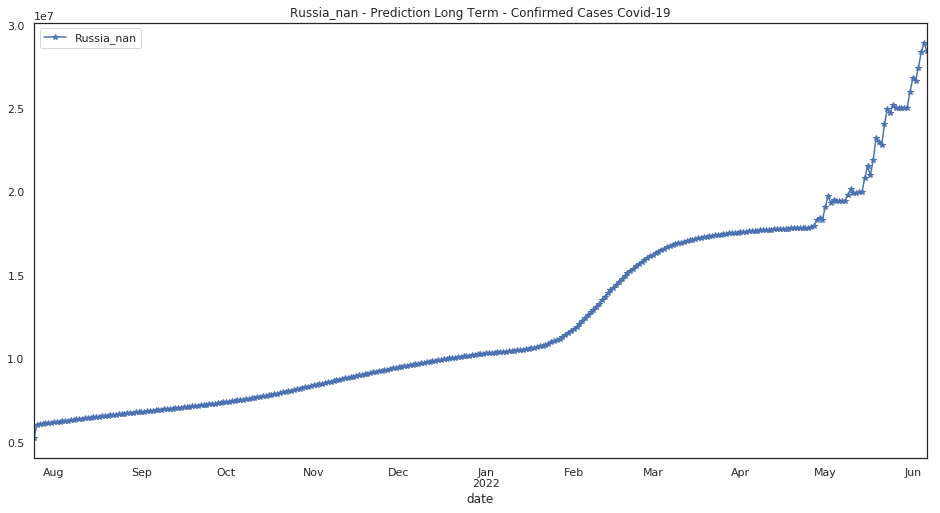

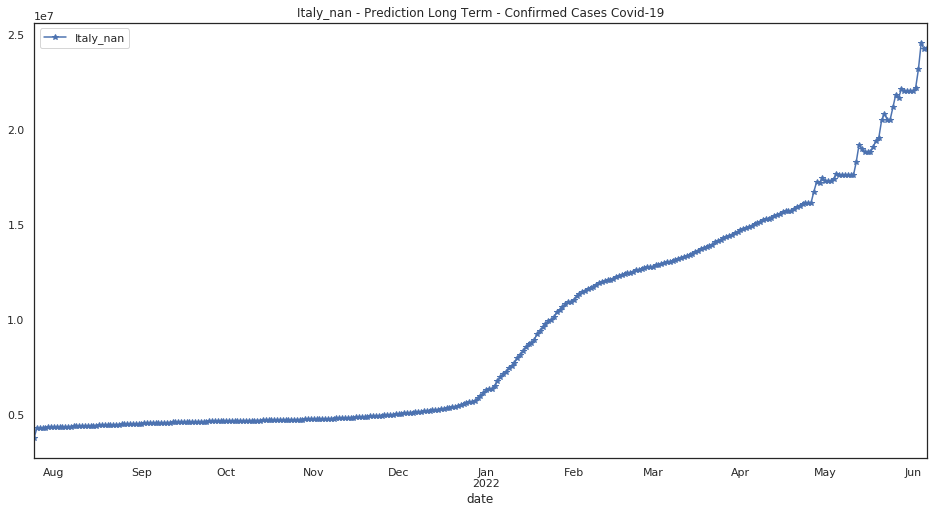

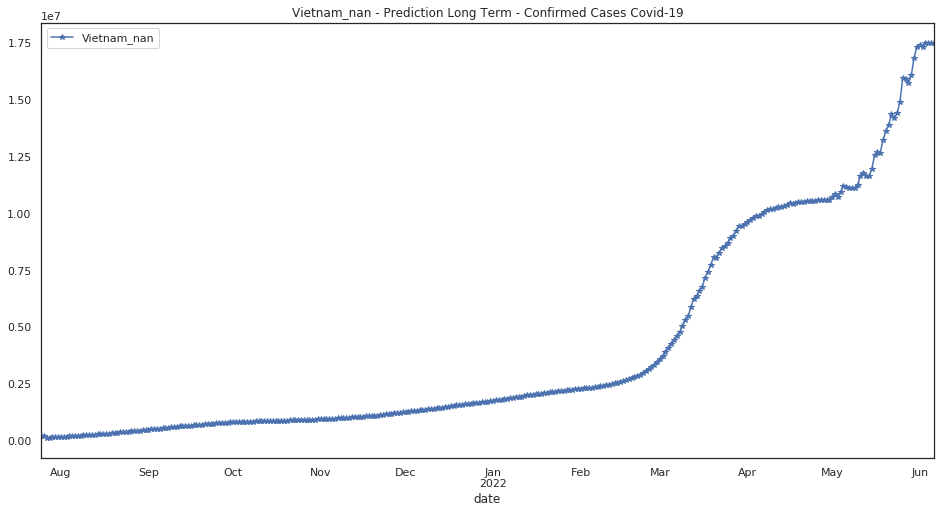

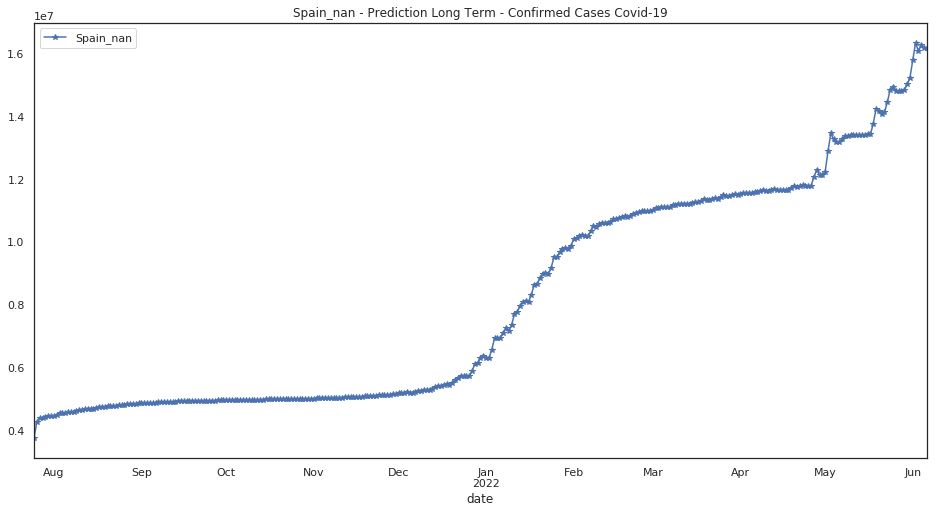

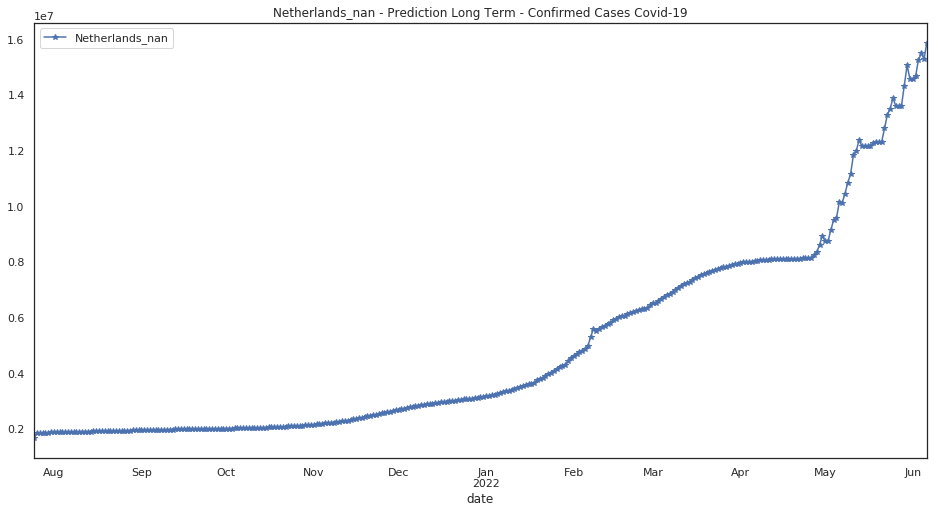

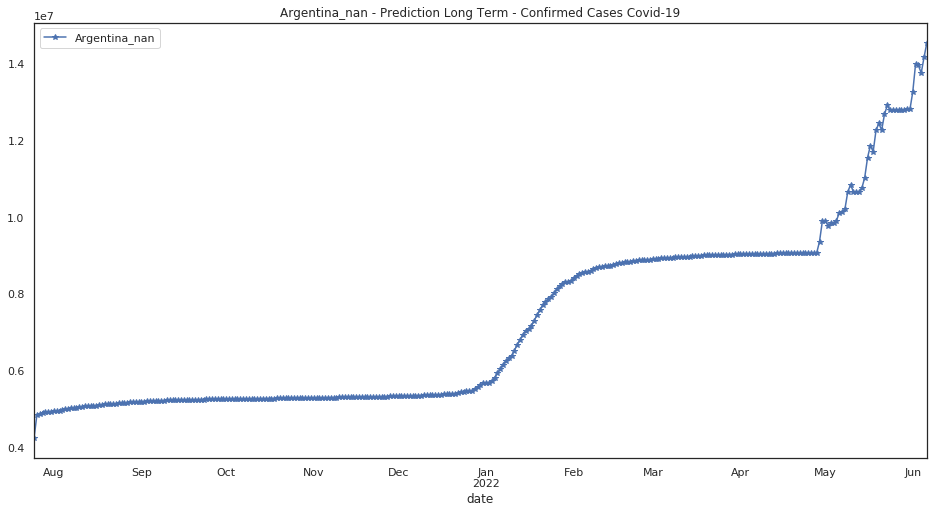

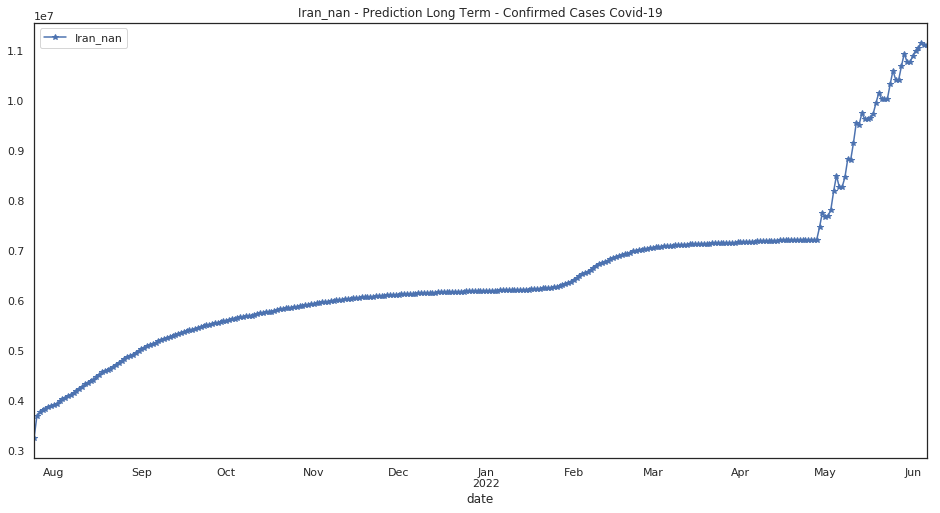

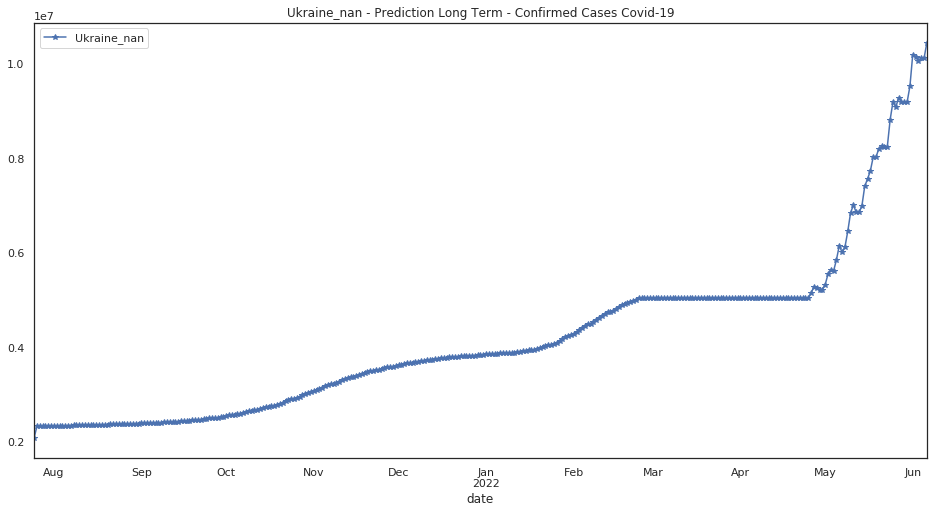

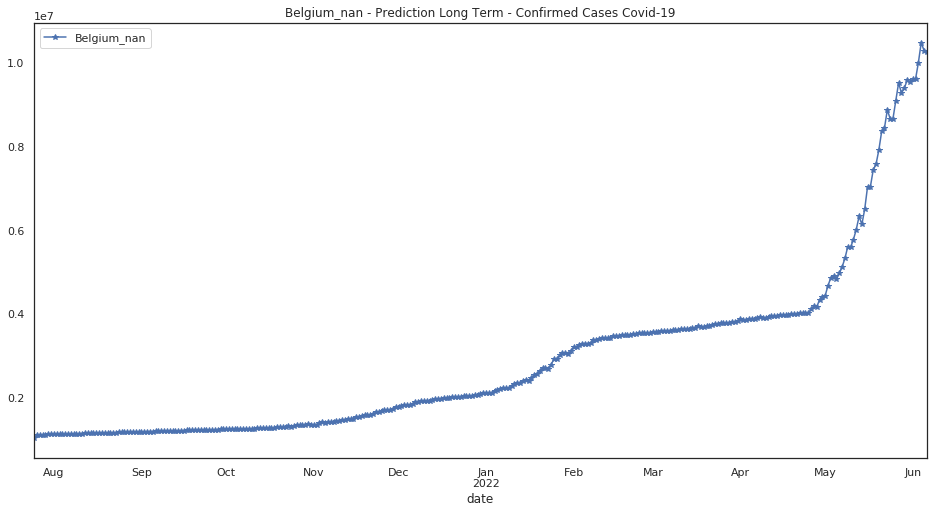

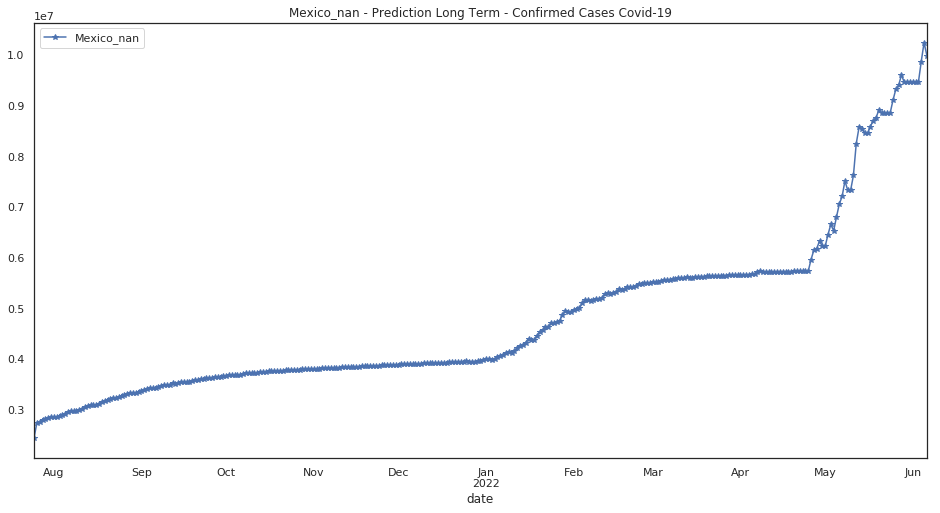

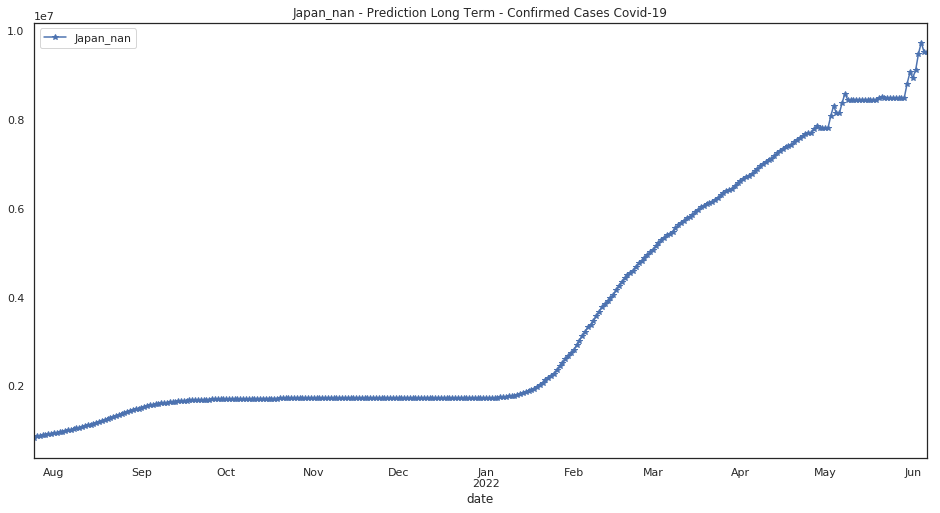

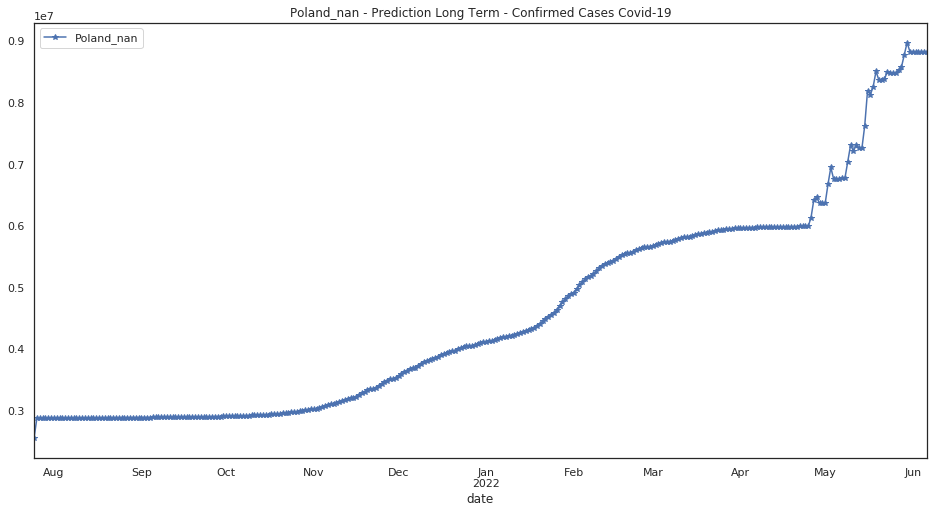

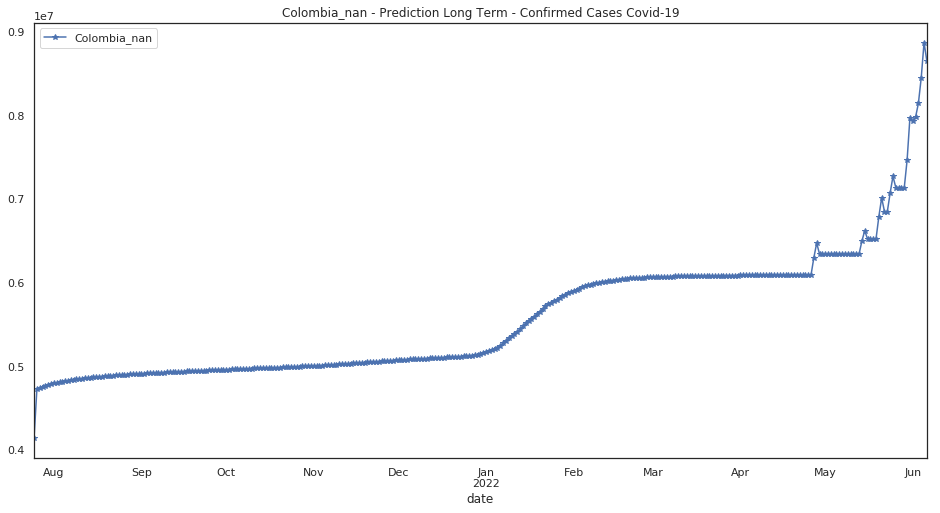

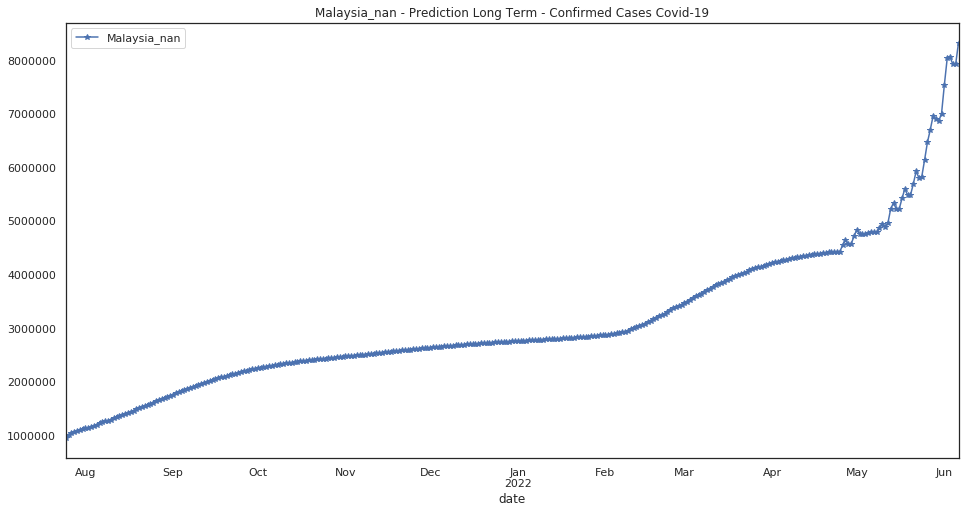

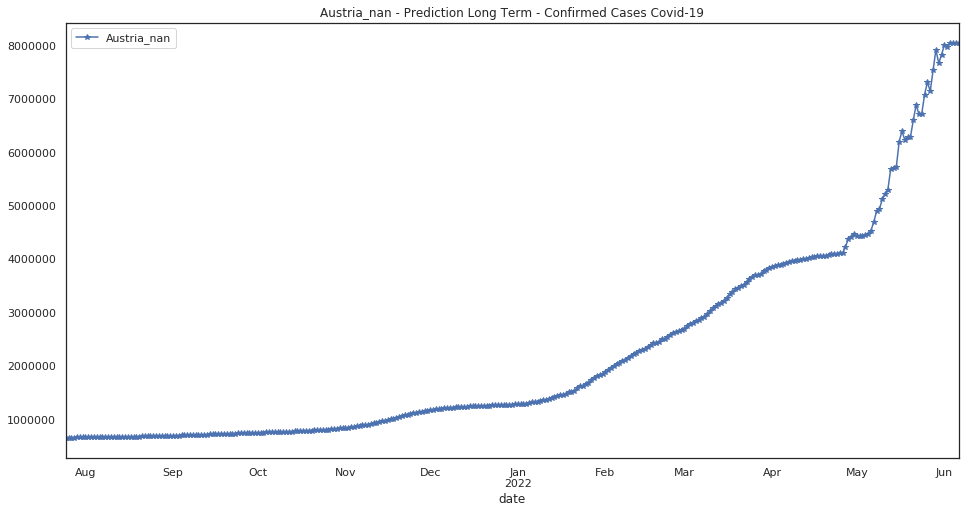

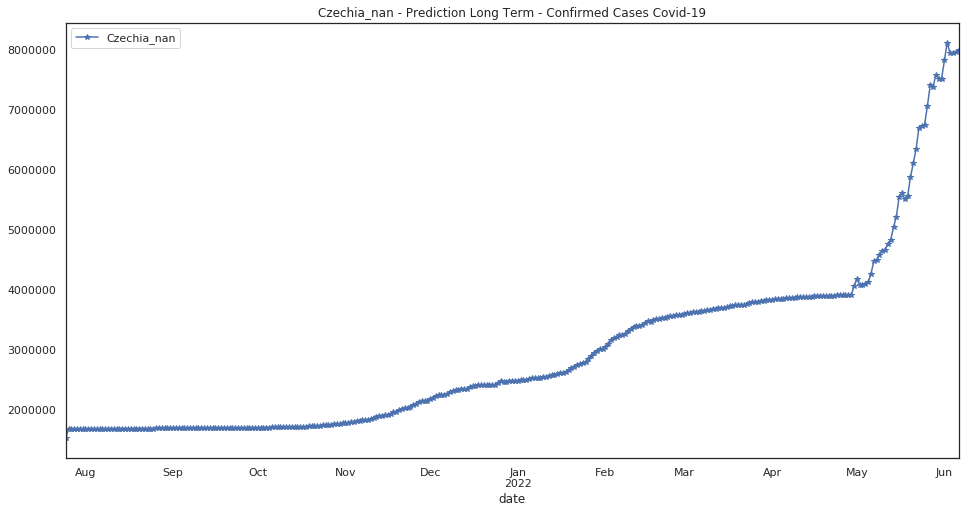

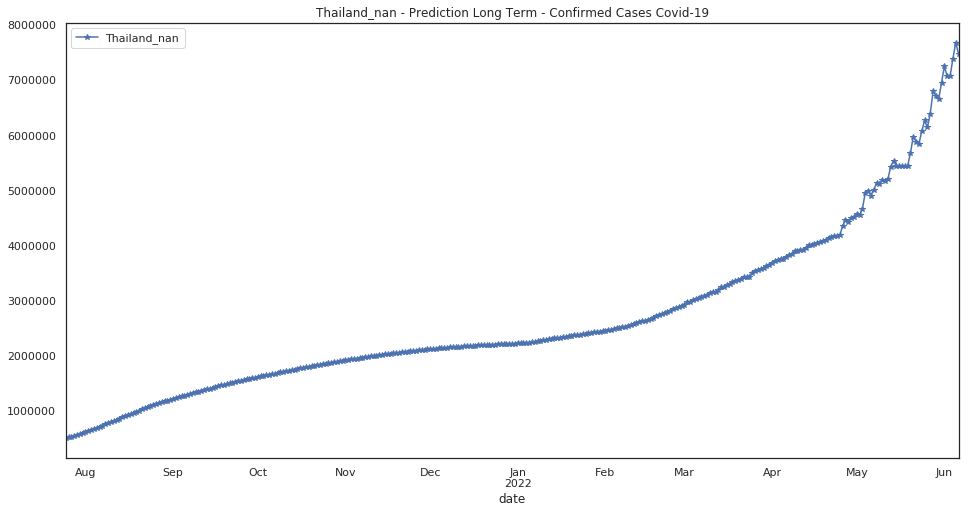

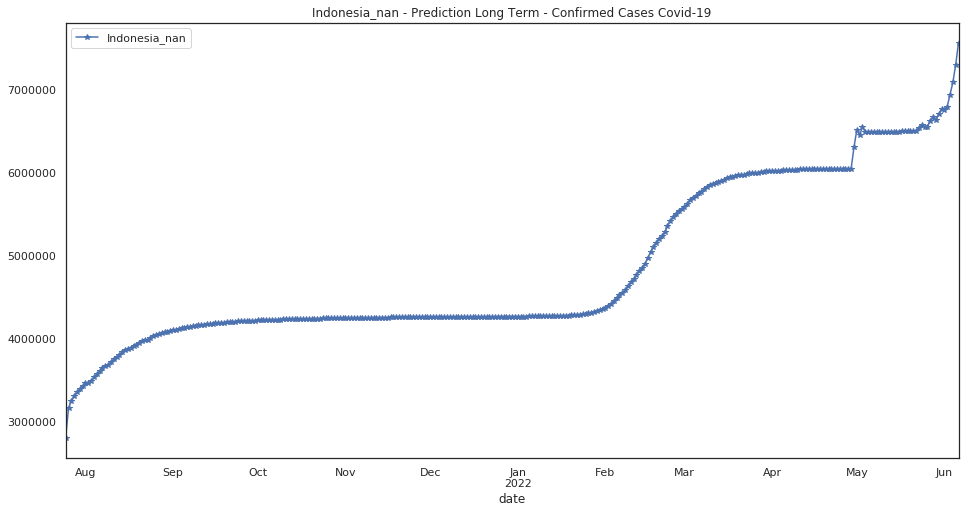

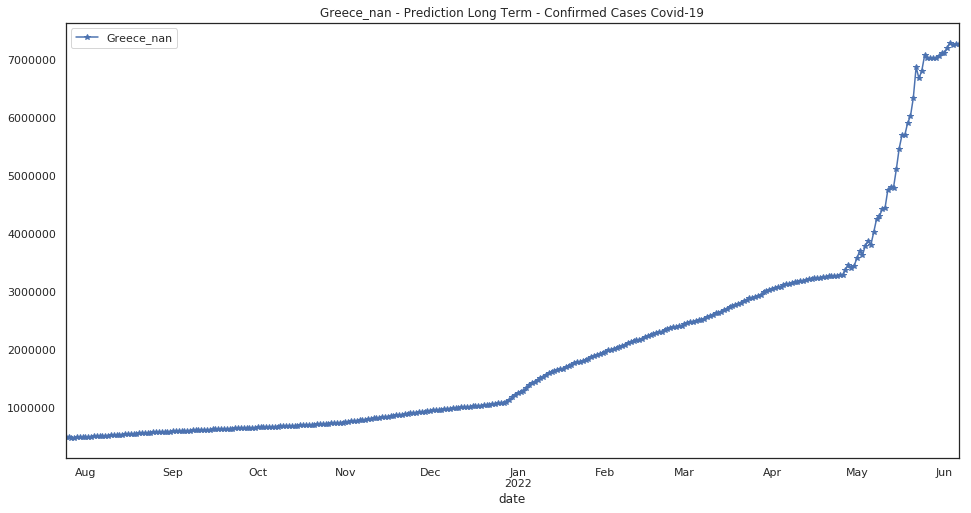

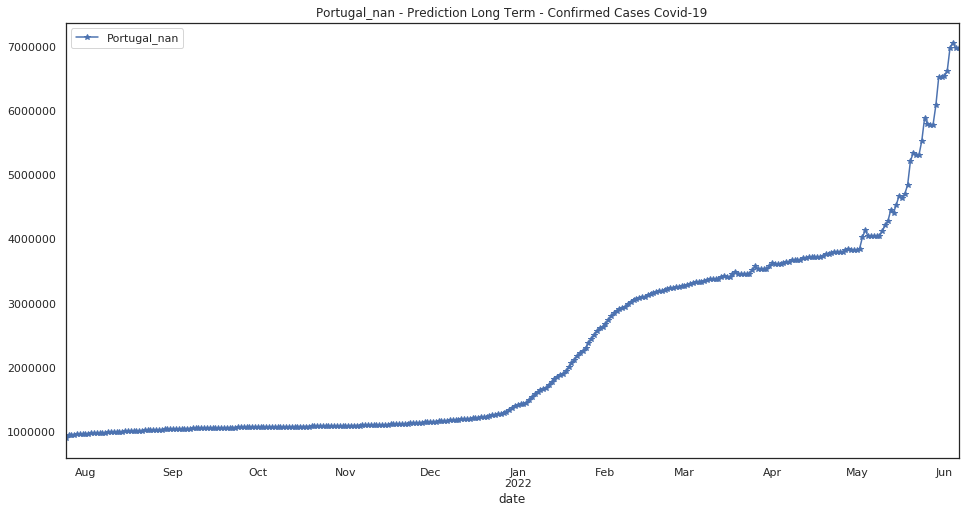

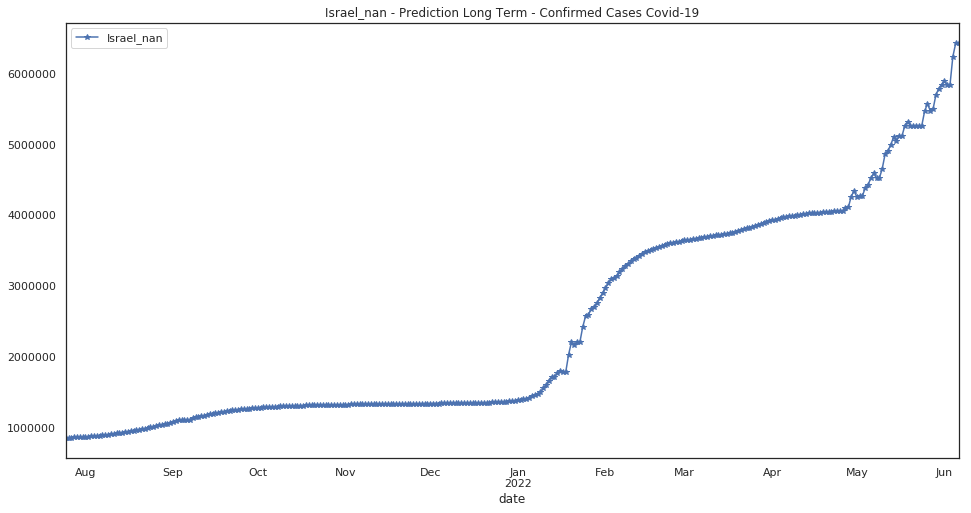

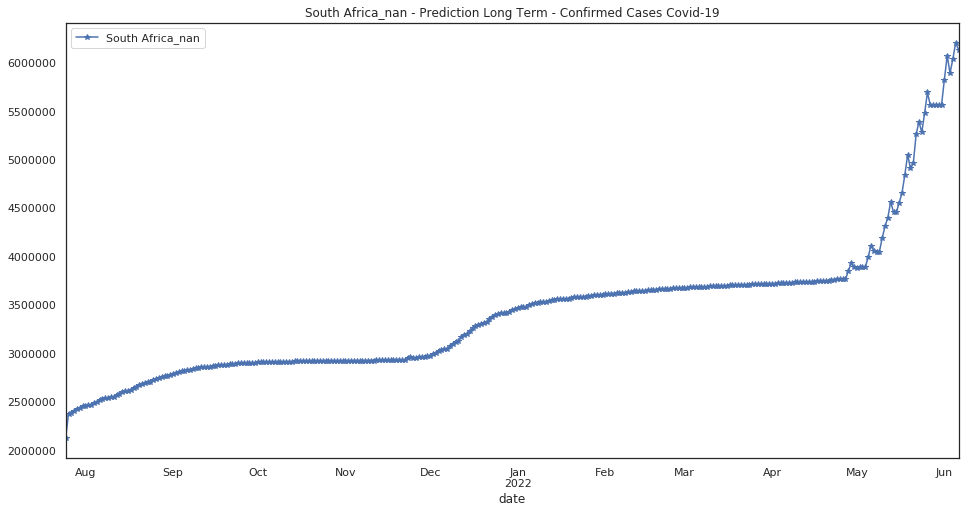

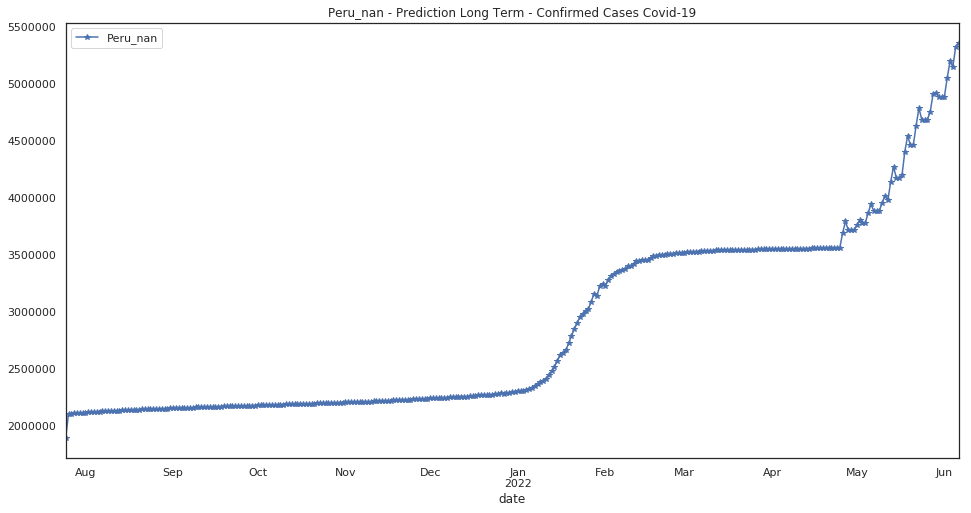

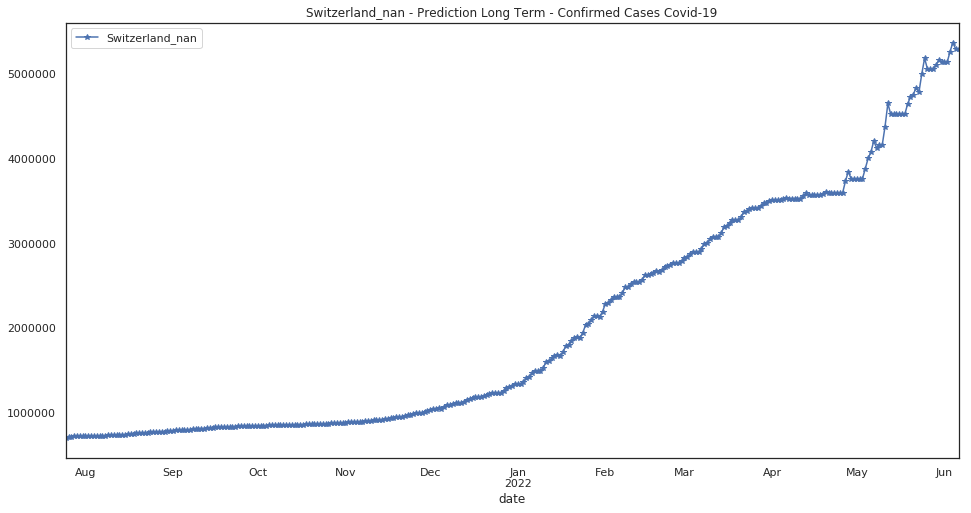

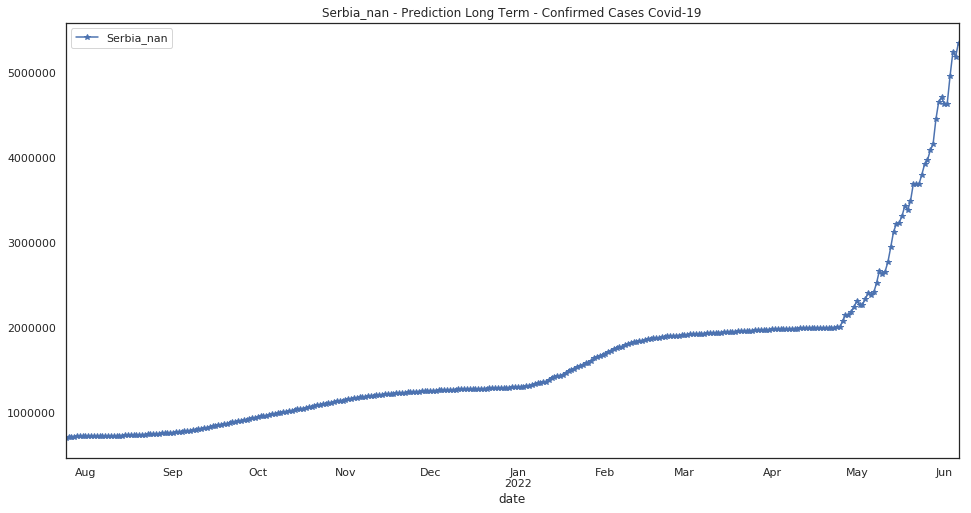

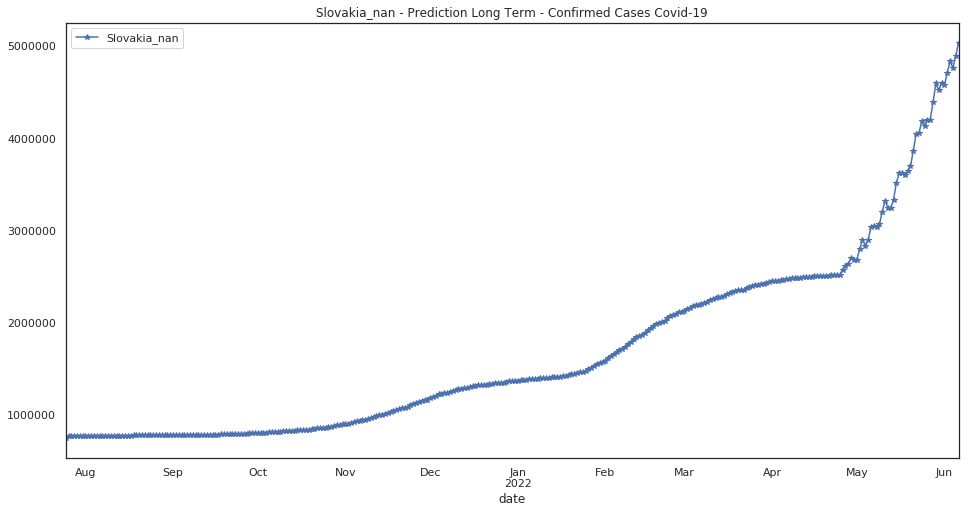

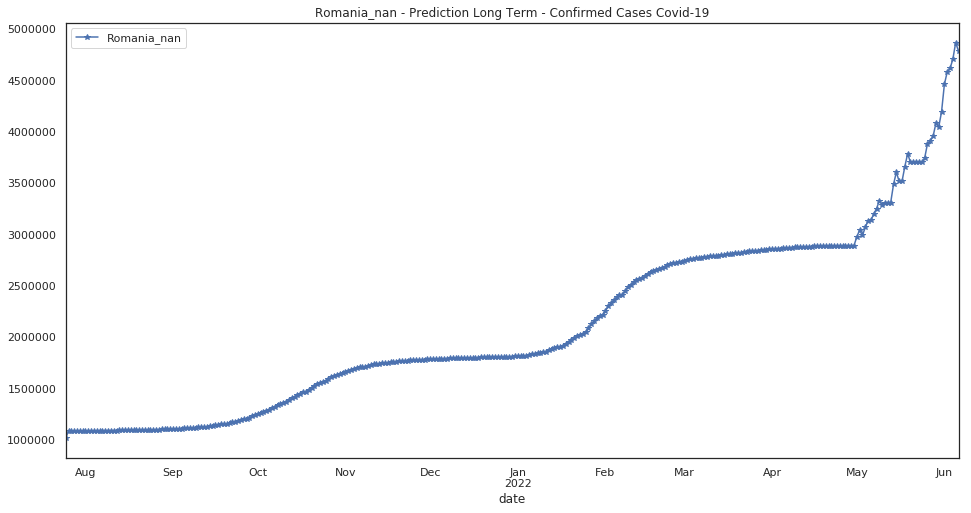

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

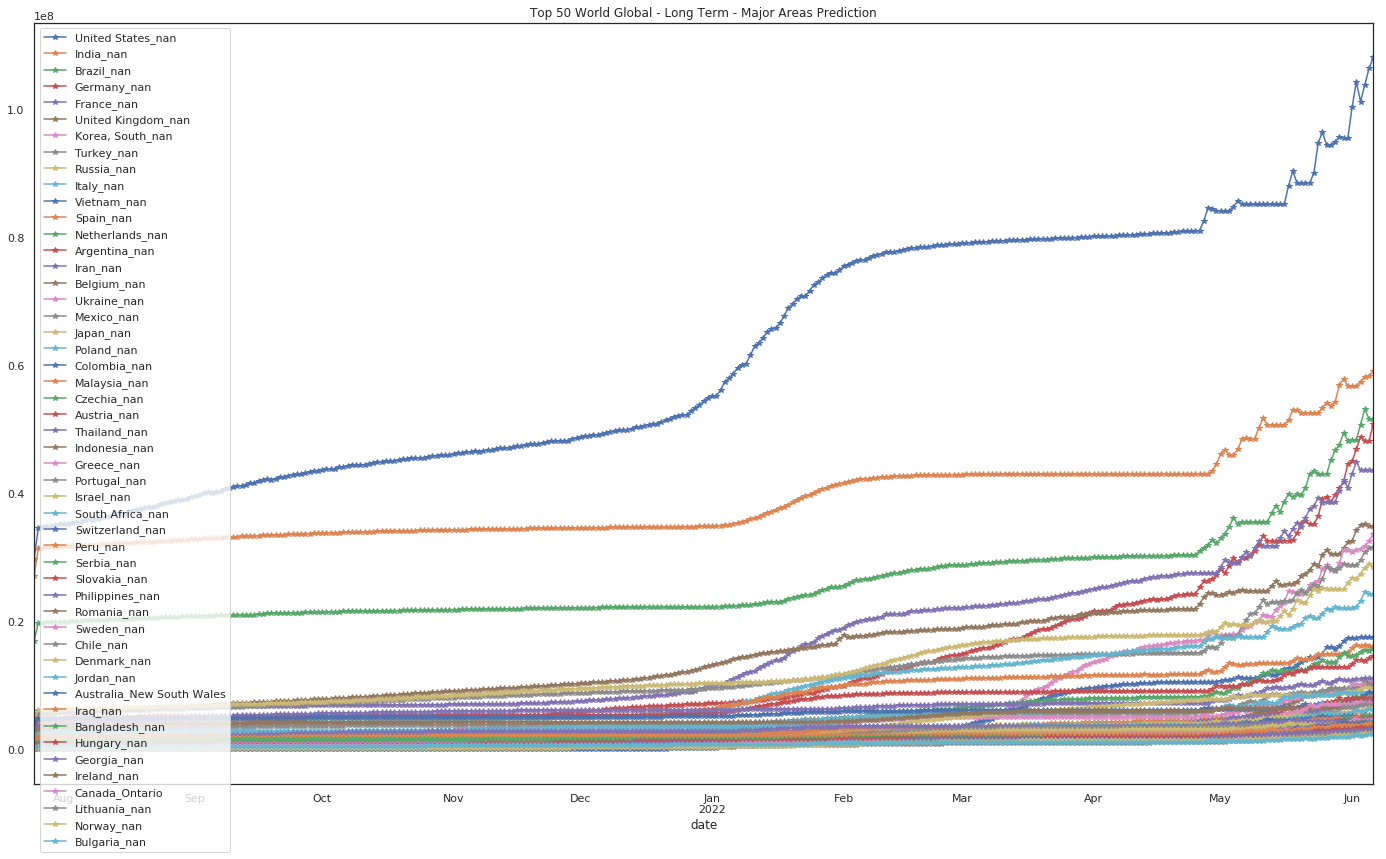

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

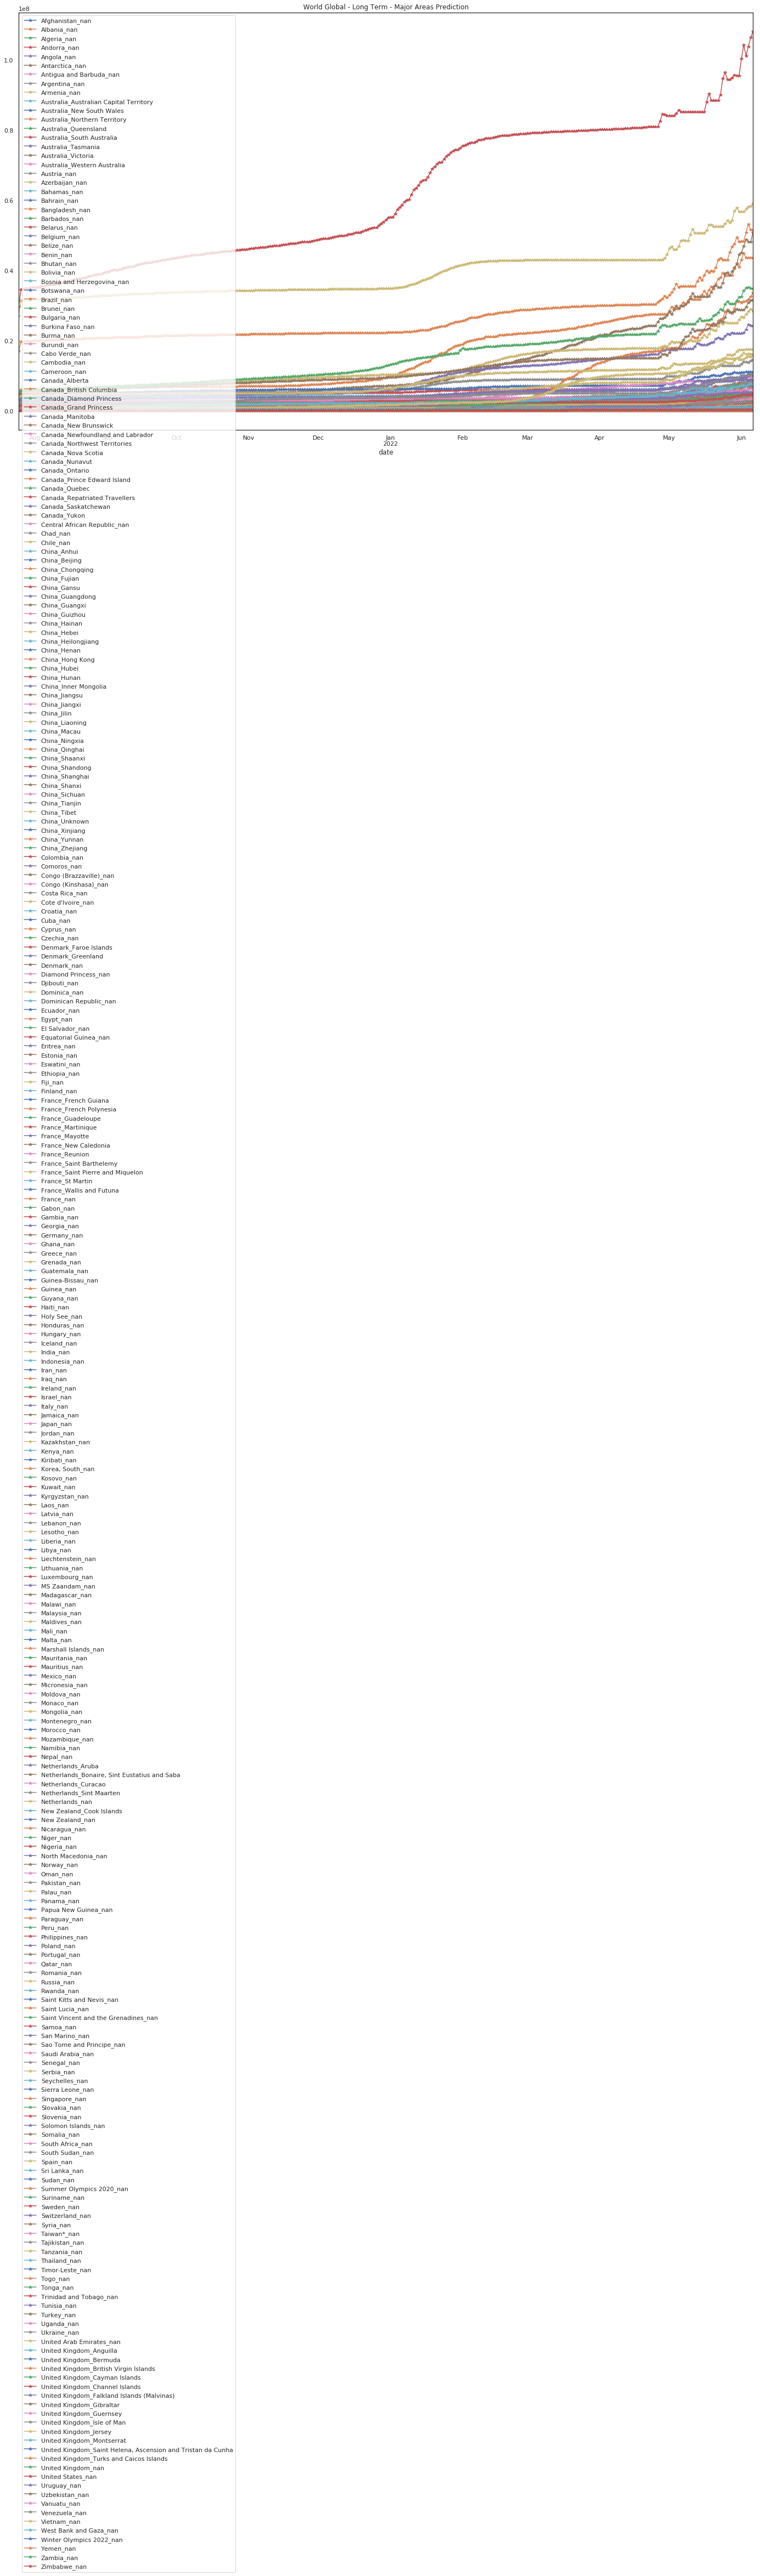

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-09-08         155392.0     154248.0     200517.0      15338.0   
2021-09-09         155496.0     155267.0     200835.0      15349.0   
2021-09-10         155612.0     156256.0     201128.0      15309.0   
2021-09-11         155645.0     157144.0     201393.0      15327.0   
2021-09-12         155648.0     158003.0     201641.0      15354.0   
2021-09-13         155735.0     158473.0     201877.0      15363.0   
2021-09-14         155827.0     159349.0     202106.0      15298.0   
2021-09-15         155930.0     160356.0     202350.0      15361.0   
2021-09-16         156016.0     161315.0     202579.0      15336.0   
2021-09-17         156135.0     162292.0     202813.0      15365.0   
2021-09-18         156155.0     163156.0     203025.0      15336.0   
2021-09-19         156148.0     163935.0     203200.0      15393.0   
2021-09-20         156230.0     164427.0     203366.0      15405.0   
2021-09-21         156355.0     165196.0     203546.0      15321.0   
2021-09-22         156416.0     166058.0     203726.0      15418.0   
2021-09-23         156461.0     166840.0     203892.0      15355.0   
2021-09-24         156604.0     167675.0     204058.0      15415.0   
2021-09-25         156630.0     168371.0     204193.0      15375.0   
2021-09-26         156623.0     168920.0     204334.0      15431.0   
2021-09-27         156717.0     169245.0     204493.0      15449.0   
2021-09-28         156753.0     169765.0     204661.0      15338.0   
2021-09-29         156789.0     170470.0     204821.0      15456.0   
2021-09-30         156836.0     171160.0     204979.0      15398.0   
2021-10-01         156855.0     171828.0     205139.0      15418.0   
2021-10-02         156864.0     172400.0     205281.0      15486.0   
2021-10-03         156862.0     172871.0     205410.0      15481.0   
2021-10-04         156943.0     172926.0     205535.0      15516.0   
2021-10-05         156983.0     173583.0     205665.0      15296.0   
2021-10-06         157045.0     174263.0     205794.0      15527.0   
2021-10-07         157100.0     174787.0     205902.0      15486.0   
...                     ...          ...          ...          ...   
2022-05-08         192701.0     336602.0     284501.0      44715.0   
2022-05-09         192048.0     346088.0     285067.0      44809.0   
2022-05-10         192060.0     352641.0     285067.0      44809.0   
2022-05-11         192216.0     355133.0     288800.0      46315.0   
2022-05-12         192216.0     377971.0     290570.0      46315.0   
2022-05-13         194978.0     383660.0     299598.0      47554.0   
2022-05-14         195825.0     394530.0     304560.0      48646.0   
2022-05-15         200908.0     413956.0     303615.0      50918.0   
2022-05-16         206195.0     416239.0     305042.0      50918.0   
2022-05-17         206341.0     435955.0     303644.0      50918.0   
2022-05-18         205619.0     467180.0     303644.0      50918.0   
2022-05-19         205417.0     472856.0     315595.0      50918.0   
2022-05-20         216751.0     466883.0     321440.0      52530.0   
2022-05-21         220850.0     466883.0     320008.0      52530.0   
2022-05-22         218447.0     466883.0     321152.0      55527.0   
2022-05-23         222121.0     469974.0     320139.0      56549.0   
2022-05-24         223179.0     469974.0     320139.0      56549.0   
2022-05-25         232175.0     494775.0     329418.0      56549.0   
2022-05-26         243132.0     522686.0     334217.0      59470.0   
2022-05-27         243477.0     532397.0     331409.0      61969.0   
2022-05-28         242300.0     545305.0     338752.0      61969.0   
2022-05-29         246991.0     566116.0     349828.0      61969.0   
2022-05-30         256451.0     578212.0     350743.0      63450.0   
2022-05-31         269730.0     570281.0     355704.0      64896.0   
2022-06-01

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                                       Antarctica_nan -71.949900   23.347000   
6                              Antigua and Barbuda_nan  17.060800  -61.796400   
7                                        Argentina_nan -38.416100  -63.616700   
8                                          Armenia_nan  40.069100   45.038200   
9               Australia_Australian Capital Territory -35.473500  149.012400   
10                           Australia_New South Wales -33.868800  151.209300   
11                        Australia_Northern Territory -12.463400  130.845600   
12                                Australia_Queensland -27.469800  153.025100   
13                           Australia_South Australia -34.928500  138.600700   
14                                  Australia_Tasmania -42.882100  147.327200   
15                                  Australia_Victoria -37.813600  144.963100   
16                         Australia_Western Australia -31.950500  115.860500   
17                                         Austria_nan  47.516200   14.550100   
18                                      Azerbaijan_nan  40.143100   47.576900   
19                                         Bahamas_nan  25.025885  -78.035889   
20                                         Bahrain_nan  26.027500   50.550000   
21                                      Bangladesh_nan  23.685000   90.356300   
22                                        Barbados_nan  13.193900  -59.543200   
23                                         Belarus_nan  53.709800   27.953400   
24                                         Belgium_nan  50.833300    4.469936   
25                                          Belize_nan  17.189900  -88.497600   
26                                           Benin_nan   9.307700    2.315800   
27                                          Bhutan_nan  27.514200   90.433600   
28                                         Bolivia_nan -16.290200  -63.588700   
29                          Bosnia and Herzegovina_nan  43.915900   17.679100   
..                                                 ...        ...         ...   
260                                        Tunisia_nan  33.886917    9.537499   
261                                         Turkey_nan  38.963700   35.243300   
262                                  United States_nan  40.000000 -100.000000   
263                                         Uganda_nan   1.373333   32.290275   
264                                        Ukraine_nan  48.379400   31.165600   
265                           United Arab Emirates_nan  23.424076   53.847818   
266                            United Kingdom_Anguilla  18.220600  -63.068600   
267                             United Kingdom_Bermuda  32.307800  -64.750500   
268              United Kingdom_British Virgin Islands  18.420700  -64.640000   
269                      United Kingdom_Cayman Islands  19.313300  -81.254600   
270                     United Kingdom_Channel Islands  49.372300   -2.364400   
271         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
272                           United Kingdom_Gibraltar  36.140800   -5.353600   
273                            United Kingdom_Guernsey  49.448196   -2.589490   
274                         United Kingdom_Isle of Man  54.236100   -4.548100   
275                              United Kingdom_Jersey  49.213800   -2.135800   
276                          United Kingdom_Montserrat  16.742498  -62.187366   
277  United Kingdom_Saint Helena, Ascension and Tri...  -7.946700  -14.355900  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                     region        Lat        Long  \
0       7              Argentina_nan -38.416100  -63.616700   
1      10  Australia_New South Wales -33.868800  151.209300   
2      17                Austria_nan  47.516200   14.550100   
3      21             Bangladesh_nan  23.685000   90.356300   
4      24                Belgium_nan  50.833300    4.469936   
5      31                 Brazil_nan -14.235000  -51.925300   
6      33               Bulgaria_nan  42.733900   25.485800   
7      52             Canada_Ontario  51.253800  -85.323200   
8      60                  Chile_nan -35.675100  -71.543000   
9      95               Colombia_nan   4.570900  -74.297300   
10    104                Czechia_nan  49.817500   15.473000   
11    107                Denmark_nan  56.263900    9.501800   
12    133                 France_nan  46.227600    2.213700   
13    136                Georgia_nan  42.315400   43.356900   
14    137                Georgia_nan  42.315400   43.356900   
15    138                Germany_nan  51.165691   10.451526   
16    140                 Greece_nan  39.074200   21.824300   
17    150                Hungary_nan  47.162500   19.503300   
18    152                  India_nan  20.593684   78.962880   
19    153              Indonesia_nan  -0.789300  113.921300   
20    154                   Iran_nan  32.427908   53.688046   
21    155                   Iraq_nan  33.223191   43.679291   
22    156                Ireland_nan  53.142400   -7.692100   
23    157                 Israel_nan  31.046051   34.851612   
24    158                 Israel_nan  31.046051   34.851612   
25    159                  Italy_nan  41.871940   12.567380   
26    161                  Japan_nan  36.204824  138.252924   
27    162                 Jordan_nan  31.240000   36.510000   
28    166           Korea, South_nan  35.907757  127.766922   
29    178              Lithuania_nan  55.169400   23.881300   
30    183               Malaysia_nan   4.210484  101.975766   
31    190                 Mexico_nan  23.634500 -102.552800   
32    204            Netherlands_nan  52.132600    5.291300   
33    211                 Norway_nan  60.472000    8.468900   
34    218                   Peru_nan  -9.190000  -75.015200   
35    219            Philippines_nan  12.879721  121.774017   
36    220                 Poland_nan  51.919400   19.145100   
37    221               Portugal_nan  39.399900   -8.224500   
38    223                Romania_nan  45.943200   24.966800   
39    224                 Russia_nan  61.524010  105.318756   
40    234                 Serbia_nan  44.016500   21.005900   
41    238               Slovakia_nan  48.669000   19.699000   
42    242           South Africa_nan -30.559500   22.937500   
43    244                  Spain_nan  40.463667   -3.749220   
44    249                 Sweden_nan  60.128161   18.643501   
45    250            Switzerland_nan  46.818200    8.227500   
46    255               Thailand_nan  15.870032  100.992541   
47    261                 Turkey_nan  38.963700   35.243300   
48    262          United States_nan  40.000000 -100.000000   
49    264                Ukraine_nan  48.379400   31.165600   
50    279         United Kingdom_nan  55.378100   -3.436000   
51    284                Vietnam_nan  14.058324  108.277199   

    2021-07-25 00:00:00  2021-07-26 00:00:00  2021-07-27 00:00:00  \
0             4244960.0            4846615.0            4874725.0   
1               92921.0              93071.0               8118.0   
2              649247.0             656270.0             656582.0   
3             1085472.0            1164635.0            1196142.0   
4             1041563.0            1113465.0            1117697.0   
5            16984803.0           19693277.0           19755563.0   
6              449668.0             449833.0             423879.0   
7              560764.0             560877.0             553286.0   
8             1466931.0            1609177.

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()